## The genomic regions in question

In `05_rec_compartments.ipynb` we extracted the genomic intervals of A compartments on all cell types in all combinations of the following parameters:

* Cell type: fibroblast, spermatocyte, pachytene spermatocyte, round spermatid, sperm
* Chromosome: X
* E1 restriction: full-chromosome, chromosome arms, 10Mb windows
* Resolution: 100 kb, 500 kb, ps500kb (smoothed 100kb)

Resulting in **45** .csv files. They are saved to `../results/rec_compartments/`.


## Setup inline backend

### `InlineBackend.rc`

For consistent plots that fit with pdf manus.

In [1]:
import matplotlib.pyplot as plt

# Define my params:
## Params will comply with my desired layout for the Manuscript (PDF)

notebook_rcparams = {
    'font.size': 7,
    'axes.titlesize': 8,
    'axes.labelsize': 7,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'figure.titlesize': 9,
    'figure.figsize': [6.0, 2.0],
    'figure.labelsize': 7,
    'legend.fontsize': 6,
    
}

# Apply config
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
%config InlineBackend.rc = notebook_rcparams

In [2]:
print({key:plt.rcParams[key] for key in notebook_rcparams.keys()})

{'font.size': 10.0, 'axes.titlesize': 'large', 'axes.labelsize': 'medium', 'xtick.labelsize': 'medium', 'ytick.labelsize': 'medium', 'figure.titlesize': 'large', 'figure.figsize': [6.4, 4.8], 'figure.labelsize': 'large', 'legend.fontsize': 'medium'}


In [3]:
## Apparently IPython needs this twice to understand?? 
import matplotlib.pyplot as plt

# Define my params:
## Params will comply with my desired layout for the Manuscript (PDF)

notebook_rcparams = {
    'font.size': 7,
    'axes.titlesize': 8,
    'axes.labelsize': 7,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'figure.titlesize': 9,
    'figure.figsize': [6.0, 2.0],
    'figure.labelsize': 7,
    'legend.fontsize': 6,
    
}

# Apply config
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
%config InlineBackend.rc = notebook_rcparams

In [4]:
print({key:plt.rcParams[key] for key in notebook_rcparams.keys()})

{'font.size': 7.0, 'axes.titlesize': 8.0, 'axes.labelsize': 7.0, 'xtick.labelsize': 6.0, 'ytick.labelsize': 6.0, 'figure.titlesize': 9.0, 'figure.figsize': [6.0, 2.0], 'figure.labelsize': 7.0, 'legend.fontsize': 6.0}


## Import compartments

In [5]:
import pandas as pd
import os

# Directory containing your .csv files
csv_dir = '../results/rec_compartments/'

# Create a dictionary to store the DataFrames
dataframes = {}

# Iterate over all .csv files in the directory
for filename in os.listdir(csv_dir):
    if filename.endswith('.csv') and 'e1' not in filename:  # Check for .csv files
        # Construct the full file path
        filepath = os.path.join(csv_dir, filename)
        
        # Load the CSV into a DataFrame
        # Use the filename (without extension) as the dictionary key
        key = filename.replace('_a_comp_coords_', '_')
        key = os.path.splitext(key)[0]
        dataframes[key] = pd.read_csv(filepath)
        dataframes[key]['length'] = dataframes[key]['end'] - dataframes[key]['start']

# The `dataframes` dictionary now contains the DataFrames
dataframes.keys()

ech90 = pd.read_csv('../data/ech90_human_Mmul_10.csv')
ech90['length'] = ech90['end'] - ech90['start']

# Load the chromosome sizes
chromsizes = (pd.read_csv(
    '../data/rheMac10.filtered.chrom.sizes', 
    sep='\t', 
    index_col='chrom', 
    header=None, 
    names=['chrom','size'])
.to_dict()['size']
)


## Define a plotting function

In [6]:
# Kaspers plotting function
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'svg'

def plot_intervals(query=None, annot=None, **kwargs):

    tups = []
    if query is not None:
        tups.append(('query', query))
    if annot is not None:
        tups.append(('annot', annot))
    tups.extend(kwargs.items())
    tups = reversed(tups)

    df_list = []
    labels = []
    for label, df in tups:
        labels.append(label)
        df['label'] = label
        df_list.append(df)
    bigdf = pd.concat(df_list)

    bigdf['chrom'] = pd.Categorical(bigdf['chrom'], bigdf['chrom'].unique())
    bigdf['label'] = pd.Categorical(bigdf['label'], bigdf['label'].unique())

    gr = bigdf.groupby('chrom', observed=False)
    fig, axes = plt.subplots(gr.ngroups, 1, figsize=(10, 1.5*gr.ngroups), 
                            sharey=True
                            #  sharex=True
                             )
    if type(axes) is not np.ndarray:
        # in case there is only one axis so it not returned as a list
        axes = np.array([axes])
    
    # with plt.style.context(('default')):

    for i, chrom in enumerate(gr.groups):
        _df = gr.get_group(chrom)
        _gr = _df.groupby('label', observed=False)
        for y, label in enumerate(_gr.groups):
            try:
                df = _gr.get_group(label)
            except KeyError:
                continue
            y = np.repeat(y, df.index.size)
            axes[i].hlines(y, df.start.tolist(), df.end.tolist(), alpha=0.5, lw=5, colors=f'C{y[0]}')
            delta = len(labels)/10
            axes[i].vlines(df.start.tolist(), y-delta, y+delta, alpha=0.5, lw=2, colors=f'C{y[0]}')
            axes[i].vlines(df.end.tolist(), y-delta, y+delta, alpha=0.5, lw=2, colors=f'C{y[0]}')

        axes[i].spines['top'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['right'].set_visible(False)

        axes[i].set_yticks(list(range(len(labels))), labels)
        axes[i].tick_params(axis='y', which='both', left=False)
        axes[i].set_ylim(-1, len(labels)-0.7)
        # axes[i].set_xlim(df.start.min()-delta, df.end.max()+delta)
        if i != gr.ngroups-1:
            axes[i].tick_params(axis='x', which='both', bottom=False)

        axes[i].set_title(chrom, loc='left', fontsize=10)
    plt.tight_layout()

In [7]:
# My plotting function

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from genominterv import interval_intersect


def plot_regions(query=None, annot=None, intersect=None, 
                 track_titles=['query', 'annot', 'intersect'], 
                 figsize=(10, 1)):
    chrom = annot['chrom'].unique()[0]
    rhemac_chromsizes = pd.read_csv('../data/rheMac10.filtered.chrom.sizes', sep='\t', header=None, names=['chrom', 'size'])
    annot_max = annot['end'].max()
    query_max = query['end'].max() if query is not None else 0
    rhemac_chromsize = rhemac_chromsizes.query(f'chrom == "{chrom}"').loc[:, 'size'].values[0]
    chromsize = max([rhemac_chromsize, annot_max, query_max])
    # Define the plot size

    f, ax = plt.subplots(figsize=figsize, sharex=True)
    ax.spines[:].set_visible(False)

    # Plot the annot
    # Iterate over each interval in the DataFrame
    for start, end in zip(annot['start'], annot['end']):
        rect = Rectangle((start, 0.1), width=end-start, height=0.9, color='tab:red', linewidth=0, alpha=0.8)
        ax.add_patch(rect)
        ax.spines['bottom'].set_visible(True)
        ax.set_ylabel(track_titles[1], rotation=0, labelpad=10, ha='right')

    
    divider = make_axes_locatable(ax)

    if query is not None:
        qax = divider.append_axes("top", size="100%", pad=0.05, sharex=ax)
        qax.xaxis.set_visible(False)
        # Plot the query
        for start, end in zip(query['start'], query['end']):
            rect = Rectangle((start, 0.1), width=end-start, height=0.9, color='tab:blue', linewidth=0, alpha=0.8)
            qax.add_patch(rect)
            qax.spines[:].set_visible(False)
            qax.set_yticks([]) 
            qax.set_title(chrom, loc='left')
            qax.set_ylabel(track_titles[0], rotation=0, labelpad=10, ha='right')
    
    if intersect is not None:
        iax = divider.append_axes("bottom", size="100%", pad=0.05, sharex=ax)
        # Invisible x-axis for 'annot' (intersect ie below) 
        ax.xaxis.set_visible(False)
        # Plot the intersect
        for start, end in zip(intersect['start'], intersect['end']):
            rect = Rectangle((start, 0.1), width=end-start, height=0.9, color='tab:green', linewidth=0, alpha=0.8)
            iax.add_patch(rect)
            iax.spines[:].set_visible(False)
            iax.set_yticks([]) 
            ax.spines['bottom'].set_visible(False)
            iax.spines['bottom'].set_visible(True)
            iax.set_ylabel(track_titles[2], rotation=0, labelpad=10, ha='right')



    ax.set_yticks([])
    ax.set_xlim(0, chromsize)
    ticks = np.linspace(0, chromsize, num=5)
    ax.set_xticks(ticks) 
    ax.set_xticklabels([f'{int(t/1e6)} Mbp' for t in ticks])
    plt.tight_layout()



## Time to unleash `genominterv` on the .csv files


### Test with a subsample of the data

(<Figure size 1000x225 with 3 Axes>, <Axes: ylabel='annot'>)

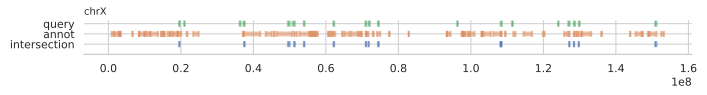

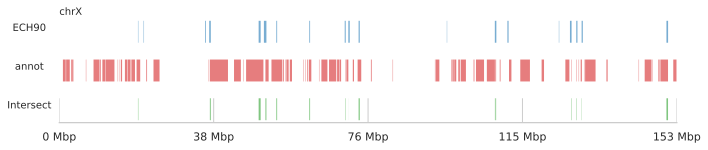

In [16]:

annot = dataframes['round_spermatid_100kb_arms']
query = ech90
intersect = interval_intersect(annot, query)

plot_intervals(query, annot, intersection=intersect)
plot_regions(query, annot, intersect)

Tests for round_spermatid_100kb_arms_smoothed
Proximity: TestResult(statistic=0.3711999999999999, pvalue=0.0204)
Jaccard: 0.03771152626674943

Tests for round_spermatid_100kb_10Mb
Proximity: TestResult(statistic=0.51525, pvalue=0.0)
Jaccard: 0.046023479610810235

Tests for round_spermatid_100kb_10Mb_smoothed
Proximity: TestResult(statistic=0.46520000000000006, pvalue=0.0049)
Jaccard: 0.042623832902054265

Tests for round_spermatid_100kb_arms
Proximity: TestResult(statistic=0.37199999999999966, pvalue=0.0121)
Jaccard: 0.046543092859550536



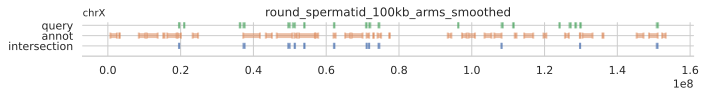

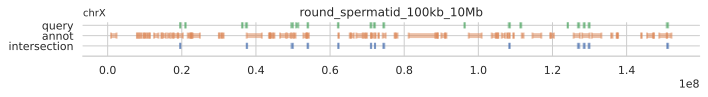

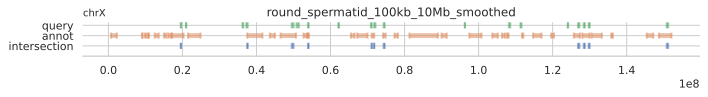

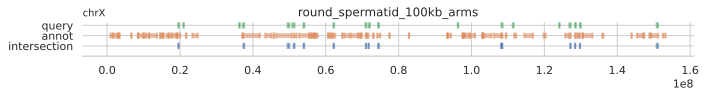

In [17]:
from genominterv import proximity_test, interval_collapse, interval_diff, interval_intersect, jaccard_stat

annot = dataframes['round_spermatid_100kb_arms']
query = ech90

#plot_intervals(query=query, annot=annot)

for key,annot in dataframes.items():
    # Filter out subset
    if ('round_spermatid_100') in key and not 'full' in key:
        # Plot the intervals
        intersection = interval_intersect(query, annot)
        plot_intervals(query=query, annot=annot, intersection=intersection)
        plt.title(key)

        # Do a proximity test
        print(f"Tests for {key}")
        annot_collapsed = interval_collapse(annot)
        non_ovl_query = interval_diff(query, annot_collapsed)
        print("Proximity:", proximity_test(non_ovl_query, annot_collapsed))
        print("Jaccard:", jaccard_stat(query, annot))
        print()



### Bootstrap to get a p-value

In [6]:
from genominterv import bootstrap

annot = dataframes['round_spermatid_100kb_arms']
chromsizes = pd.read_csv('../data/rheMac10.filtered.chrom.sizes', sep='\t', index_col='chrom', header=None, names=['chrom','size']).to_dict()['size']
#display(chromsizes)

@bootstrap(chromsizes, samples=1000)
def jaccard_bootstrap(query, annot):
    return jaccard_stat(query, annot)

jacccard_stat, p_value = jaccard_bootstrap(query, annot)

In [7]:
jacccard_stat, p_value

(0.046543092859550536, 0.112)

### Partition the A-compartments into regions *around* the edges 

In [8]:
from genominterv import interval_collapse, interval_union

df = dataframes['round_spermatid_100kb_arms']

start_edge = pd.DataFrame({
    'chrom': df['chrom'],
    'start': df.apply(lambda x: max(x['start'] - x['resolution'], 0), axis=1),
    'end': df['start']+1*df['resolution'],
    'resolution': df['resolution'],
    'label': 'start_edge'
})
end_edge = pd.DataFrame({
    'chrom': df['chrom'],
    'start': df['end']-1*df['resolution'],
    'end': df.apply(lambda x: min(x['end'] + x['resolution'], chromsizes['chrX']), axis=1),
    'resolution': df['resolution'],
    'label': 'end_edge'
})

# The end cannot exceed the chromosome size
test_df = pd.concat([start_edge, end_edge]).sort_values(['chrom', 'start', 'end'])
interval_collapse(test_df)

,start,end,chrom
0,800000,1000000,chrX
1,1500000,1800000,chrX
2,2500000,2700000,chrX
3,2800000,3300000,chrX
4,3400000,3600000,chrX
...,...,...,...
91,148700000,148900000,chrX
92,149000000,149400000,chrX
93,151100000,151300000,chrX
94,152400000,152600000,chrX


In [9]:
import os
from genominterv import interval_collapse

for key, df in dataframes.items():
    outdir = '../results/rec_edges'
    edge_csv_name = os.path.join(outdir,f'{key+'_edges.csv'}')
    if not os.path.exists(edge_csv_name):
        res = df['resolution'].unique()[0]

        start_edge = pd.DataFrame({
            'chrom': df['chrom'],
            'start': df.apply(lambda x: max(x['start'] - x['resolution'], 0), axis=1),
            'end': df['start']+1*df['resolution'],
            'resolution': df['resolution'],
            'label': 'start_edge'
        })
        end_edge = pd.DataFrame({
            'chrom': df['chrom'],
            'start': df['end']-1*df['resolution'],
            'end': df.apply(lambda x: min(x['end'] + x['resolution'], chromsizes['chrX']), axis=1),
            'resolution': df['resolution'],
            'label': 'end_edge'
        })

        if not os.path.exists(outdir):
            os.makedirs(outdir)

        tmp = pd.concat([start_edge, end_edge]).sort_values(['chrom', 'start', 'end'])
        interval_collapse(tmp).assign(resolution=res).to_csv(edge_csv_name, index=False)


## Import edges

In [8]:
import pandas as pd
import os

# Directory containing your .csv files
csv_dir = '../results/rec_edges/'

# Create a dictionary to store the DataFrames
edge_df = {}

# Iterate over all .csv files in the directory
for filename in os.listdir(csv_dir):
    if filename.endswith('.csv'):  # Check for .csv files
        # Construct the full file path
        filepath = os.path.join(csv_dir, filename)
        
        # Load the CSV into a DataFrame
        # Use the filename (without extension) as the dictionary key
        key = filename.replace('_edges_', '')
        key = os.path.splitext(key)[0]
        edge_df[key] = pd.read_csv(filepath)
        edge_df[key]['length'] = edge_df[key]['end'] - edge_df[key]['start']

# The `edges` dictionary now contains the DataFrames
print(edge_df.keys())
print(edge_df['fibroblast_100kb_10Mb_edges'].columns)

#ech90 = pd.read_csv('../data/ech90_human_Mmul_10.csv')


dict_keys(['pachytene_spermatocyte_100kb_arms_smoothed_edges', 'round_spermatid_100kb_arms_smoothed_edges', 'fibroblast_500kb_arms_edges', 'round_spermatid_500kb_10Mb_edges', 'fibroblast_100kb_full_edges', 'round_spermatid_500kb_arms_edges', 'spermatogonia_100kb_arms_smoothed_edges', 'fibroblast_500kb_10Mb_edges', 'round_spermatid_100kb_full_edges', 'spermatogonia_500kb_arms_edges', 'spermatogonia_100kb_full_edges', 'pachytene_spermatocyte_100kb_arms_edges', 'sperm_500kb_full_edges', 'pachytene_spermatocyte_500kb_full_edges', 'sperm_100kb_arms_edges', 'sperm_100kb_arms_smoothed_edges', 'sperm_100kb_10Mb_edges', 'pachytene_spermatocyte_100kb_10Mb_edges', 'fibroblast_100kb_arms_smoothed_edges', 'spermatogonia_500kb_10Mb_edges', 'round_spermatid_100kb_full_smoothed_edges', 'fibroblast_500kb_full_edges', 'round_spermatid_100kb_10Mb_edges', 'pachytene_spermatocyte_100kb_full_smoothed_edges', 'fibroblast_100kb_arms_edges', 'sperm_100kb_10Mb_smoothed_edges', 'round_spermatid_500kb_full_edges'

In [9]:
from genominterv import interval_intersect

samples = dataframes.keys()
#samples = ['round_spermatid_100kb_arms', 'round_spermatid_100kb_10Mb', 'sperm_100kb_arms', 'sperm_100kb_10Mb']

comps = {key:dataframes[key] for key in samples}
edges = {key:edge_df[f'{key}_edges'] for key in samples}

comp_intersects = {key:interval_intersect(comp, ech90).assign(length = lambda x: x['end'] - x['start']) for key, comp in comps.items()}
edge_intersects = {key:interval_intersect(edge, ech90).assign(length = lambda x: x['end'] - x['start']) for key, edge in edges.items()}




## For a single sample only ##
# sample = 'round_spermatid_100kb_arms'

# full_df = dataframes[sample]
# full_intersect = interval_intersect(full_df, ech90).assign(length=lambda x: x['end'] - x['start'])
# edge_intersect = interval_intersect(edge_df[f'{sample}_edges'], ech90).assign(length=lambda x: x['end'] - x['start'])

# edge_df = edge_df[f'{sample}_edges']

# # Plot full
# plot_regions(ech90, full_df, full_intersect)
# plt.suptitle('All edges')

# # Plot edge
# plot_regions(ech90, edge_df, edge_intersect)
# plt.suptitle('Edges only')


In [ ]:
### Some stats about the data and intersections ###

stats = pd.DataFrame({
    'Sample': samples,
    'Total regions': [comp.shape[0] for comp in comps.values()],
    'Total regions on ECH90': [comp_intersect.shape[0] for comp_intersect in comp_intersects.values()],
    'Total regions on edges': [edge_intersect.shape[0] for edge_intersect in edge_intersects.values()],
    'Prop regions on ECH90': [comp_intersect.shape[0] / ech90.shape[0] for comp, comp_intersect in zip(comps.values(), comp_intersects.values())],
    'Total bp': [comp['length'].sum() for comp in comps.values()],
    'Total bp on ECH90': [comp_intersect['length'].sum() for comp_intersect in comp_intersects.values()],
    'Total bp on edges': [edge_intersect['length'].sum() for edge_intersect in edge_intersects.values()],
    'Prop bp on ECH90': [comp_intersect['length'].sum() / ech90['length'].sum() for comp, comp_intersect in zip(comps.values(), comp_intersects.values())],
})


#df[['Source', 'Rest']] = df['Sample'].str.extract(r'^(.*?)(_\d+\w+.*)')
stats[['source', 'res', 'view', 'smoothed']] = stats['Sample'].str.extract(r'^(.*?)_(100kb|500kb)_(full|arms|10Mb)(?:_(smoothed))?$')
stats['smoothed'] = stats['smoothed'].notna() # Convert to boolean
stats[['source', 'res', 'view', 'smoothed','Prop regions on ECH90', 'Prop bp on ECH90']]



,source,res,view,smoothed,Prop regions on ECH90,Prop bp on ECH90
0,spermatogonia,500kb,arms,False,0.421053,0.489351
1,round_spermatid,500kb,full,False,0.368421,0.418981
2,fibroblast,500kb,full,False,0.684211,0.529916
3,pachytene_spermatocyte,100kb,arms,True,0.684211,0.632145
4,pachytene_spermatocyte,500kb,full,False,0.368421,0.362651
5,pachytene_spermatocyte,100kb,full,False,0.473684,0.365265
6,round_spermatid,100kb,arms,True,0.631579,0.412828
7,fibroblast,100kb,arms,True,0.684211,0.499297
8,fibroblast,100kb,full,False,0.842105,0.550167
9,round_spermatid,100kb,full,False,0.421053,0.472204


## Do testing of the edges

In [9]:
%%capture
# Define what we are testing

print("""
Goal: To test whether ECH90 regions are enriched in compartment edges
Query: ECH90
Annotation: Start and end edges of compartments

Hypothesis: 
      ECH90 regions are enriched in compartment edges
Null hypothesis: 
      ECH90 regions are not enriched in compartment edges

Tests: 
* Proximity test: 
      tests whether the query regions are closer to 
      the annotation regions than expected by chance. 
      NB regions can not overlap, so we need to collapse the annotation regions

* Jaccard index: 
      tests the similarity between the query and annotation regions, 
      where a value of 1 indicates perfect overlap
""")

### Big test don't run

#### Parallelized proximity test

set samples = 100_000

In [15]:
import os.path as op
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from genominterv.stats import proximity_test
from genominterv import interval_diff


def process_proximity(sample, nsamples = 100000):
    query_comp = ech90
    query_edge = ech90
    annot_comp = comps[sample]
    annot_edge = edges[sample]

    # Get non-overlapping query regions
    non_ovl_query_comp = interval_diff(query_comp, annot_comp)
    non_ovl_query_edge = interval_diff(query_edge, annot_edge)

    proximity_comp = proximity_test(non_ovl_query_comp, annot_comp, 
                                    nsamples, two_sided=False,
                                    overlap_as_zero=True)
    proximity_edge = proximity_test(non_ovl_query_edge, annot_edge, 
                                    nsamples, two_sided=False,
                                    overlap_as_zero=True,span_as_zero=True)

    results = [
        {'Sample': sample, 'Query': 'ECH90', 'Comp Statistic': proximity_comp.statistic, 
         'Edge Statistic': proximity_edge.statistic, 'Comp P-value': proximity_comp.pvalue, 
         'Edge P-value': proximity_edge.pvalue}
    ]

    # Swap query and annotation
    query_comp, annot_comp = annot_comp, query_comp
    query_edge, annot_edge = annot_edge, query_edge

    non_ovl_query_comp = interval_diff(query_comp, annot_comp)
    non_ovl_query_edge = interval_diff(query_edge, annot_edge)

    proximity_comp = proximity_test(non_ovl_query_comp, annot_comp, 
                                    nsamples, two_sided=False,
                                    overlap_as_zero=True)
    proximity_edge = proximity_test(non_ovl_query_edge, annot_edge, 
                                    nsamples, two_sided=False,
                                    overlap_as_zero=True)

    results.append(
        {'Sample': sample, 'Query': 'Edge', 'Comp Statistic': proximity_comp.statistic, 
         'Edge Statistic': proximity_edge.statistic, 'Comp P-value': proximity_comp.pvalue, 
         'Edge P-value': proximity_edge.pvalue}
    )

    return results

### End of function definition ###


nsamples = 100_000
proximity_file = f'../results/proximity_test_{nsamples}.csv'
if op.exists(proximity_file):
    proximity_res = Parallel(n_jobs=-1)(
        delayed(process_proximity)(sample, nsamples) for sample in tqdm(samples)
    )

    # Flatten the results
    proximity_res = pd.DataFrame([item for sublist in proximity_res for item in sublist])
    proximity_res.to_csv(proximity_file, index=False)


100%|██████████| 2/2 [00:00<00:00, 120.90it/s]


TypeError: proximity_test() got an unexpected keyword argument 'span_as_zero'

#### Parallelized Jaccard test

In [17]:
from joblib import Parallel, delayed
from tqdm import tqdm
import os.path as op
from genominterv.stat import jaccard_stat
from genominterv.decorators import bootstrap
from datetime import datetime
import pandas as pd

b = 100_000
@bootstrap(chromsizes, samples=b)
def jaccard_bootstrap(query, annot):
    return jaccard_stat(query, annot)

def process_sample(sample):
    """Function to process a single sample."""
    query_comp = ech90
    query_edge = ech90
    annot_comp = comps[sample]
    annot_edge = edges[sample]

    jaccard_comp = jaccard_bootstrap(query_comp, annot_comp)
    jaccard_edge = jaccard_bootstrap(query_edge, annot_edge)

    result = [{
        'Sample': sample, 
        'Query': 'ECH90', 
        'Comp Index': jaccard_comp[0], 
        'Edge Index': jaccard_edge[0], 
        'Comp P-value': jaccard_comp[1], 
        'Edge P-value': jaccard_edge[1]
        }
    ]

    # Swap query and annotation for the Edge test
    query_comp, annot_comp = annot_comp, query_comp
    query_edge, annot_edge = annot_edge, query_edge

    jaccard_comp = jaccard_bootstrap(query_comp, annot_comp)
    jaccard_edge = jaccard_bootstrap(query_edge, annot_edge)

    result.append({
        'Sample': sample, 
        'Query': 'Edge', 
        'Comp Index': jaccard_comp[0], 
        'Edge Index': jaccard_edge[0], 
        'Comp P-value': jaccard_comp[1], 
        'Edge P-value': jaccard_edge[1]
        }
    )
    return result

jaccard_file = f'../results/jaccard_test_{b}.csv'

if not op.exists(jaccard_file):

    # Run parallel computation
    print(f"Running bootstrap ({b}) for all samples in parallel")
    results = Parallel(n_jobs=-1)(
        delayed(process_sample)(sample) for sample in tqdm(samples)
    )

    # Flatten and create DataFrame
    jaccard_res = pd.DataFrame([item for sublist in results for item in sublist])

    # Write to CSV
    jaccard_res.to_csv(jaccard_file, index=False)

else:
    # Read
    jaccard_res = pd.read_csv(jaccard_file)


#### Plot some summary statistics

In [33]:
# Split sample column:
proximity_res = pd.read_csv(proximity_file)

proximity_res[['source', 'resolution', 'view', 'smoothed']] = proximity_res['Sample'].str.extract(r'^(.*?)_(100kb|500kb)_(full|arms|10Mb)(?:_(smoothed))?$')
proximity_res['source'] = proximity_res['source'].map({'fibroblast':'Fib', 'spermatogonia': 'SP', 'pachytene_spermatocyte': 'PAC', 'round_spermatid': 'RS', 'sperm': 'Sperm'})
proximity_res['smoothed'] = proximity_res['smoothed'].notna()
proximity_res['resolution'] = proximity_res.apply(lambda x: 'ps500kb' if x['smoothed'] else x['resolution'], axis=1)
proximity_res = proximity_res.melt(
    id_vars=['Sample', 'source', 'resolution', 'view', 'Query'],
    value_vars=['Comp P-value', 'Edge P-value'], 
     var_name='type', value_name='p-value',).query('Query == "ECH90"')

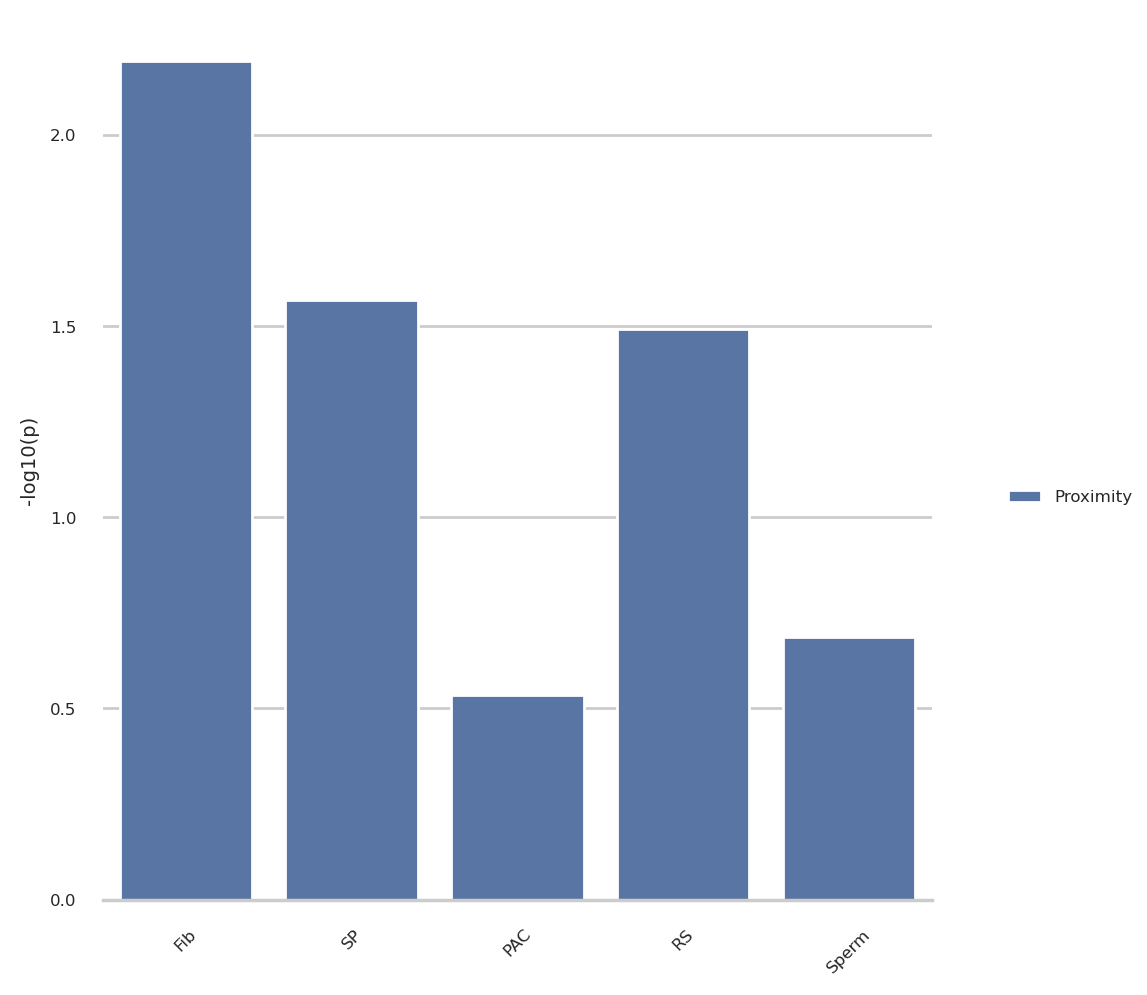

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

source_order = ['Fib', 'SP', 'PAC', 'RS', 'Sperm']
# Choose the combination og parameters to plot
source = ['fibroblast','round_spermatid']
res = ['100kb']
view = ['arms']
annot = ['Edge P-value']

# Plot the results from @group
plot_group_prox = proximity_res.query('resolution in @res and view in @view and type in @annot')

plot_group_prox = plot_group_prox.assign(
    minuslog10p = lambda x: -np.log10(x['p-value']),
    type = 'Proximity')

# Plot the results

sns.set_theme(style="whitegrid", rc=notebook_rcparams)

g = sns.catplot(
    plot_group_prox, kind='bar',
    x='source', y='minuslog10p', hue='type', 
    order=source_order,
    errorbar=None, margin_titles=True, sharex=False,
    )

g.despine(left=True)
g.set_axis_labels("", "-log10(p)")
g.legend.set_title('')


for axis in g.axes.flat:
    axis.tick_params(labelbottom=True)
    # rotate said labels
    for item in axis.get_xticklabels():
        item.set_rotation(45)

g.tight_layout()



In [35]:
# Now do the same for the Jaccard index

jaccard_res = pd.read_csv(jaccard_file)

jaccard_res[['source', 'resolution', 'view', 'smoothed']] = jaccard_res['Sample'].str.extract(r'^(.*?)_(100kb|500kb)_(full|arms|10Mb)(?:_(smoothed))?$')
jaccard_res['source'] = jaccard_res['source'].map({'fibroblast':'Fib', 'spermatogonia': 'SP', 'pachytene_spermatocyte': 'PAC', 'round_spermatid': 'RS', 'sperm': 'Sperm'})
jaccard_res['smoothed'] = jaccard_res['smoothed'].notna()
jaccard_res['resolution'] = jaccard_res.apply(lambda x: 'ps500kb' if x['smoothed'] else x['resolution'], axis=1)
jaccard_res = jaccard_res.melt(
    id_vars=['Sample', 'source', 'resolution', 'view', 'Query'],
    value_vars=['Comp P-value', 'Edge P-value'], 
    var_name='type', value_name='p-value',).query('Query == "ECH90"')



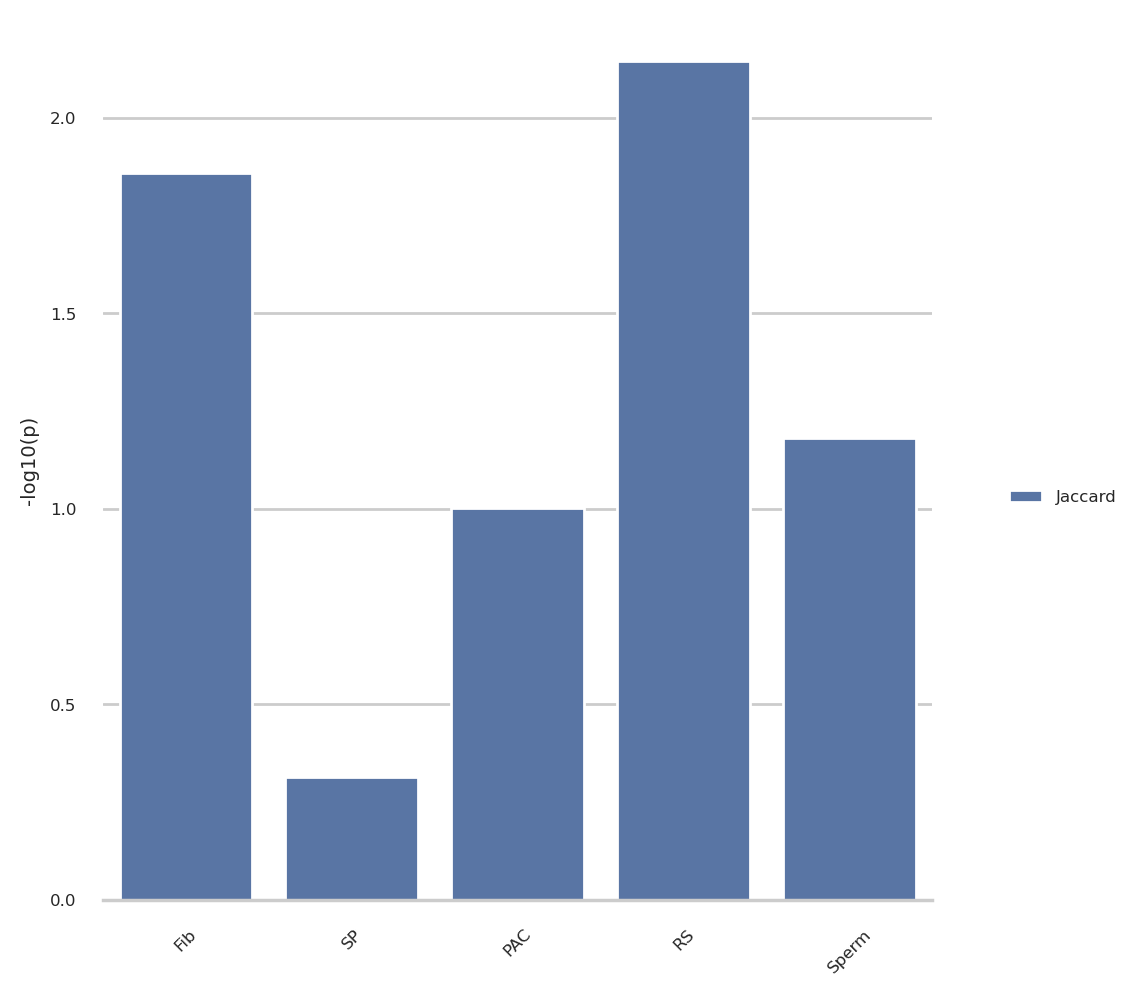

In [36]:
import numpy as np

source_order = ['Fib', 'SP', 'PAC', 'RS', 'Sperm']
# Choose the combination og parameters to plot
source = ['fibroblast','round_spermatid']
res = ['100kb']
view = ['arms']
annot = ['Edge P-value']

# Plot the results from @group
plot_group_jacc = jaccard_res.query('resolution in @res and view in @view and type in @annot')
plot_group_jacc = plot_group_jacc.assign(
    minuslog10p = lambda x: -np.log10(x['p-value']),
    type = 'Jaccard')

# Plot the results

sns.set_theme(style="whitegrid", rc=notebook_rcparams)

g = sns.catplot(
    plot_group_jacc, kind='bar',
    x='source', y='minuslog10p', hue='type', 
    order=source_order,
    errorbar=None, margin_titles=True, sharex=False,
    )

g.despine(left=True)
g.set_axis_labels("", "-log10(p)")
g.legend.set_title('')


for axis in g.axes.flat:
    axis.tick_params(labelbottom=True)
    # rotate said labels
    for item in axis.get_xticklabels():
        item.set_rotation(45)

g.tight_layout()

#### Plot proximity result with Jaccard result

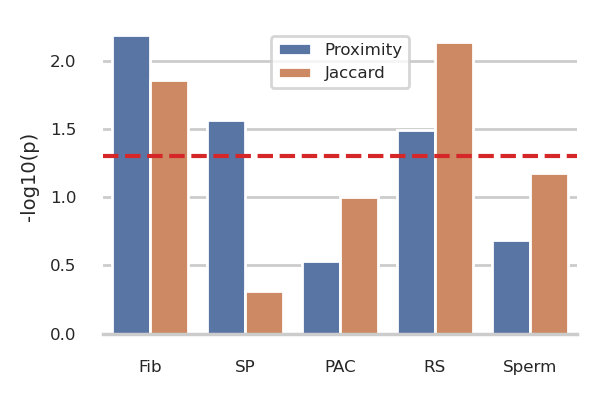

In [59]:
#| label: fig-proximity-jaccard-bar
#| fig-cap: Proximity and Jaccard index p-values for ECH90 regions on compartment edges for all cell types at 100kb resolution at arms view $p=0.05$ is marked as a red line.

# Concatenate the two plot_groups

group = pd.concat([plot_group_prox, plot_group_jacc])
# display(group[['source', 'resolution', 'type', 'p-value', 'minuslog10p']].query(
#     'source in ("Fib", "RS")'
# ).reset_index(drop=True))

# g = sns.catplot(
#     group, kind='bar',
#     x='source', y='minuslog10p', hue='type', 
#     order=source_order,
#     errorbar=None, margin_titles=True,
#     height=2, aspect=1.5
#     )
# # Plot a horisontal line at p=0.05
# g.ax.axhline(-np.log10(0.05), color='tab:red', linestyle='--')

f,ax = plt.subplots(figsize=(3,2))

# barplot
g = sns.barplot(
    data=group, x='source', y='minuslog10p', hue='type', 
    order=source_order, ax = ax
    )

ax.axhline(-np.log10(0.05), color='tab:red', linestyle='--')


sns.despine(ax=g, left=True)

g.set_ylabel('-log10(p)')
g.set_xlabel('')
g.get_legend().set_title('')
sns.move_legend(g, 'upper center', bbox_to_anchor=(0.5,0.975))

f.tight_layout()
plt.show()




#### Plot all cominations of the parameters

Avoid this to avoid p-hacking. 

In [ ]:

# # Define the order of the x-axis if we plot all combinations
# view_order = ['full', 'arms', '10Mb']
# row_order = ['Fib', 'SP', 'PAC', 'RS', 'Sperm']
#
# sns.set_theme(style="whitegrid")
#
# g = sns.catplot(
#     proximity_res, kind='bar', row='source',
#     x='view', y='p-value', hue='type', col='resolution', 
#     order=view_order, row_order=row_order,
#     errorbar=None, margin_titles=True, sharex=False,
#     )
#
# g.despine(left=True)
# g.set_axis_labels("", "P-value")
# g.legend.set_title('')
#
#
# for axis in g.axes.flat:
#     axis.tick_params(labelbottom=True)
#     # rotate said labels
#     for item in axis.get_xticklabels():
#         item.set_rotation(45)
#
# g.tight_layout()


In [ ]:

# # # Group the results by source and resolution
# # group = ["fibroblast", 'round_spermatid']
# # # Plot the results from @group
# # plot_group = jaccard_res.query(f'source in @group')
# sns.set_theme(style="whitegrid")

# view_order = ['full', 'arms', '10Mb']
# row_order = ['Fib', 'SP', 'PAC', 'RS', 'Sperm']

# g = sns.catplot(
#     jaccard_res, kind='bar', row='source',
#     x='view', y='p-value', hue='type', col='resolution', 
#     margin_titles=True, sharex=False, 
#     order=view_order, row_order=row_order,
#     errorbar=None)

# g.despine(left=True)
# g.set_axis_labels("", "P-value")
# g.legend.set_title('')
# for axis in g.axes.flat:
#     axis.tick_params(labelbottom=True)
#     # rotate said labels
#     for item in axis.get_xticklabels():
#         item.set_rotation(45)
#         item.set_va('top')

# g.tight_layout()

## Revised test (baboon)

### Baboon data

Here, the data for hybrid incompatibility in baboons (having *Papio hamadryas* or *Papio anubis* ancestry) is introduced and compared with the edge regions of the compartments. The intervals are extracted from *baboondiversity* project, in the notebook `baboon_ancestry_segments.ipynb`. 

The data originates from a baboon population in a hybridization zone between olive and hamadryas baboons, and the extracted intervals are genomic regions where (almost) all individiuals have the same ancestral allele, 100% from olive or 95% hamadryas. It has nothing to do with Hi-C data, but maybe the intervals align as well?

The intervals were lifted to *rheMac10* via *hg38*: *panu_3.0* -> *hg38* -> *rheMac10*: two intervals were deleted with no match in the last step:    

```raw
#Deleted in new
chrX	58600000	58700000	high_olive
#Deleted in new
chrX	59400000	60800000	high_olive
```

Additionally, 4 intervals were lifted to the Y chromosome, so they were deleted as well

### The tests

We think the regions where *hamadryas* ancestry is preserved are the most relevant to this analysis, as the regions are shorter and there are not as many. 

Here, perform the tests as discussed (meeting)

**Edge.v.Edge: (100kb +/- start,end)**

- `jaccard_test`
    - `query: [ech, high_hama]`
    - `annot: [rs100_arms_edge, fb100_arms_edge]`
    - Total tests: $4$
- `proximity_test(overlap_as_zero=True,span_as_zero=True)` 
    - `query: [ech, high_hama]`
    - `annot: [rs100_arms_edge, fb100_arms_edge]`
    - Total tests: $4$

**Region.v.Region**

- `jaccard_bootstrap()`
    - `query: [ech, high_hama]`
    - `annot: [rs100_arms_comp, fb100_arms_comp]`

### Load baboons

In [13]:
# Load baboons, define only high_hama

import pandas as pd
from genominterv import interval_collapse


### Lifted with standard UCSC LiftOver
# baboon_df = pd.read_csv('../results/high_baboon_rhemac10.bed', sep='\t', index_col=False, header=None, names=['chrom', 'start', 'end', 'group', 'score'])
baboon_nonlift = pd.read_csv('../results/hama_olive_high_intervals.tsv', sep='\t', index_col=False)

# # print("Original:")
# # print(baboon_df.groupby('group').size())

# high_hama = (interval_collapse(baboon_df.query('group == "high_hama"')).
#              assign(group = "high_hama").
#              query('chrom == "chrX"')
#              ).reset_index(drop=True)
# high_olive = (interval_collapse(baboon_df.query('group == "high_olive"')).
#               assign(group = "high_olive").
#               query('chrom == "chrX"')
#               )
# print("\nCollapsed:")
# #print(pd.concat([high_hama, high_olive]).groupby('group').size())


# #baboon_dict = {"P.hama": high_hama, "P.anubis": high_olive}
# print(f"high_hama: {high_hama.shape[0]}")

### Lifted with  segment_liftover (`lift` env)

high_hama = pd.read_csv('../data/lift/rheMac10/high_hama_rhemac10.bed', sep='\t', index_col=False, header=None, names=['group', 'chrom', 'start', 'end'])

high_olive = pd.read_csv('../data/lift/rheMac10/high_olive_rhemac10.bed', sep='\t', index_col=False, header=None, names=['group', 'chrom', 'start', 'end'])



#### Define functions

In [27]:
from genominterv import interval_collapse
from multiprocessing import cpu_count
from genominterv.stats import jaccard_stat, proximity_stat
from genominterv.decorators import bootstrap
import numpy as np
import pandas as pd

# Make edges function

## Make a function that splits an interval into its edges (and collapses overlapping edges)

def make_edges(df, resolution):
    start_edge = pd.DataFrame({
        'chrom': df['chrom'],
        'start': df.apply(lambda x: max(x['start'] - resolution, 0), axis=1),
        'end': df['start']+1*resolution,
        'resolution': resolution,
    })
    end_edge = pd.DataFrame({
        'chrom': df['chrom'],
        'start': df['end']-1*resolution,
        'end': df.apply(lambda x: min(x['end'] + resolution, chromsizes['chrX']), axis=1),
        'resolution': resolution,
    })

    return interval_collapse(pd.concat([start_edge, end_edge]).sort_values(['chrom', 'start', 'end'])).assign(resolution=resolution)


nsamples=100_000

@bootstrap(chromsizes, samples=nsamples)
def proximity_test(q, a):
    """
    Tests if the mean relative distance of query segments to the
    closest annotation is smaller than expected.
    """
    return proximity_stat(q, a)

@bootstrap(chromsizes, samples=nsamples)
def jaccard_test(q, a):
    """"
    Tests if the overlap between query and annotation segments 
    is smaller than expected.
    """
    return jaccard_stat(q, a)

def overlaps(df1, df2):
    """
    Establishes whether each query segment overlaps at least one 
    annotation segment. Returns a boolean array with same length 
    as df1.index.
    """
    overlapping = []
    for i, (s1, e1) in enumerate(zip(df1.start, df1.end)):
        overlaps = False
        for s2, e2 in zip(df2.start, df2.end):
            if e1 > s2 and e2 > s1:
                overlaps = True
                break
        overlapping.append(overlaps)
    return np.array(overlapping)

def svedig_tabel(orig_df, index, columns, values, cmap='Reds'):
    df = (orig_df
        .assign(log10p=np.log10(results.p))
        .loc[(results.p < 0.05)]
        .pivot(index=index, columns=columns, values=values)
    )
    df = df.rename(columns = {x:x.replace('_', '<br>') for x in df.columns.tolist()})
    df = (df.style
        .background_gradient(subset=df.columns, axis=None, cmap=cmap, vmin=0)
        .map(lambda x: 'color: transparent; background-color: transparent' if np.isnan(x) else '')
        .format('{:.3f}')
        .set_table_styles(
                {c: [{'selector': '', 
                        'props': [('min-width', '100px')],
                        }] for c in df.columns}, overwrite=False
        )
    )
    return df


### Load comps and edges

In [13]:
# Define the rest and get an overview of the selected samples

samples = ['fibroblast_100kb_arms', 'round_spermatid_100kb_arms']

fb100_dict = {
    'full':dataframes[samples[0]], 
    'edges':edge_df[f'{samples[0]}_edges'],
    'limits': make_edges(dataframes[samples[0]], 1)}

rs100_dict = {
    'full':dataframes[samples[1]],
    'edges':edge_df[f'{samples[1]}_edges'],
    'limits': make_edges(dataframes[samples[1]], 1)}

hama_dict = {
    'full': high_hama,
    'edges': make_edges(high_hama, 100_000),
    'limits': make_edges(high_hama, 1)
}

olive_dict = {
    'full': high_olive,
    'edges': make_edges(high_olive, 100_000),
    'limits': make_edges(high_olive, 1)
}

ech_dict = {'full': ech90,
            'edges': make_edges(ech90, 100_000),
            'limits': make_edges(ech90, 1)}


### Summarise

,Sample,Full_bp,full_avg_bp,Edge_bp,edge_avg_bp,edge_over_full
0,Fibroblast,"64,200,000","1,088,135.6","21,600,000","260,241.0",33.6%
1,Round spermatid,"56,500,000","733,766.2","27,088,924","282,176.3",47.9%
2,Hamadryas,"8,775,834","516,225.5","6,434,612","229,807.6",73.3%
3,Olive,"44,876,120","1,319,885.9","12,715,662","219,235.6",28.3%
4,ECH,"5,511,675","290,088.2","7,195,159","224,848.7",130.5%


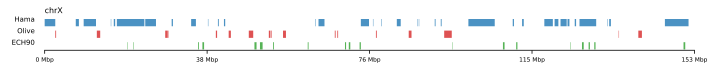

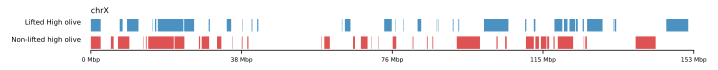

In [16]:
# Summarise how much the edges are reduced compared to the full regions

names = ['Fibroblast', 'Round spermatid', 'Hamadryas', 'Olive', 'ECH']
samples = [fb100_dict, rs100_dict, hama_dict, olive_dict, ech_dict]

# 

summary = pd.DataFrame({
    'Sample': names,
    'Full_bp': [sum(sample['full']['end'] - sample['full']['start']) for sample in samples],
    'full_avg_bp': [round(sum(sample['full']['end'] - sample['full']['start']) / sample['full'].shape[0], 1) for sample in samples],
    'Edge_bp': [sum(sample['edges']['end'] - sample['edges']['start']) for sample in samples],
    'edge_avg_bp': [round(sum(sample['edges']['end'] - sample['edges']['start']) / sample['edges'].shape[0], 1) for sample in samples],

}).assign(edge_over_full=lambda x: round(x['Edge_bp'] / x['Full_bp'],3))

# tell pandas to use thousands separator
display(summary.style.format("{:,.0f}", subset=['Full_bp', 'Edge_bp']).format("{:,.1f}", subset=['full_avg_bp', 'edge_avg_bp']).format("{:.1%}", subset='edge_over_full'))

plot_regions(high_olive, high_hama, ech90, track_titles=['Hama', 'Olive', 'ECH90'])

plot_regions(high_olive,baboon_nonlift.query('group == "high_olive"'), track_titles=['Lifted High olive', 'Non-lifted high olive'])



### Test

#### Test revised I 

In [15]:
# Now define tests 
from genominterv.decorators import bootstrap
from genominterv.stats import proximity_test, jaccard_stat
from joblib import Parallel, delayed
from tqdm import tqdm

n_samples=100_000

## Proximity test

def proximity_parallel(query, annot, nsamples=100_000, oaz=False, saz=False):
    q_key, a_key = query, annot
    query = prox_dict[q_key]
    annot = prox_dict[a_key]
    
    test = proximity_test(query, annot, nsamples, 
                          overlap_as_zero=oaz, 
                          span_as_zero=saz
                          )

    results = [
        {'Query': q_key,
         'Annot': a_key, 
         'Statistic': test.statistic, 
         'P-value': test.pvalue,
         'Overlap as zero': oaz,
         'Span as zero': saz
         }
    ]

    return results

## Jaccard bootstrap
@bootstrap(chromsizes, samples=10_000)
def jaccard_bootstrap(query, annot):
    return jaccard_stat(query, annot)

def jaccard_parallel(query, annot):
    q_key = query
    a_key = annot
    query = jacc_dict[q_key]
    annot = jacc_dict[a_key]

    test = jaccard_bootstrap(query, annot)

    results = [
        {'Query': q_key,
            'Annot': a_key, 
            'Index': test[0], 
            'P-value': test[1]
            }]
    return results

# Now do the testing
# Define the samples
prox_dict = {'ECH90': ech_dict['full'],
             'Hamadryas': hama_dict['full'],
             'Olive': olive_dict['full'],
             'Fib100_edge': fb100_dict['edges'],
             'RS100_edge': rs100_dict['edges'],
             'RS100_full': rs100_dict['full']
            }

prox_samples = [('ECH90', 'Fib100_edge', n_samples),
                ('ECH90', 'RS100_edge', n_samples),
                ('Hamadryas', 'Fib100_edge', n_samples),
                ('Hamadryas', 'RS100_edge', n_samples),
                ('Olive', 'Fib100_edge', n_samples),
                ('Olive', 'RS100_edge', n_samples),
                ('Olive', 'RS100_full', n_samples),
                ('Hamadryas', 'RS100_full', n_samples),
                ]

# First, without oaz, saz
proximity_res1 = Parallel(n_jobs=-1)(
    delayed(proximity_parallel)(que, ann, n, False, False) for (que,ann,n) in tqdm(prox_samples)
)
proximity_res1 = pd.DataFrame([item for sublist in proximity_res1 for item in sublist])

# Now with oaz, saz
proximity_res2 = Parallel(n_jobs=-1)(
    delayed(proximity_parallel)(que, ann, n, True, True) for (que,ann,n) in tqdm(prox_samples)
)
proximity_res2 = pd.DataFrame([item for sublist in proximity_res2 for item in sublist])

# Now with oaz, saz
proximity_res3 = Parallel(n_jobs=-1)(
    delayed(proximity_parallel)(que, ann, n, True, False) for (que,ann,n) in tqdm(prox_samples)
)
proximity_res3 = pd.DataFrame([item for sublist in proximity_res3 for item in sublist])


# Concatenate the results
proximity_res = pd.concat([proximity_res1, proximity_res2, proximity_res3])

# Write to CSV
#proximity_res.to_csv('../results/proximity_revised.csv', index=False)

# Now do the Jaccard index
jacc_samples = [(ech_dict['full'], fb100_dict['full']), 
                (hama_dict['full'], rs100_dict['full'])
                ]

jacc_dict = {'ECH90': ech_dict['full'],
             'Hamadryas': hama_dict['full'],
             'Olive': olive_dict['full'],
             'Fib100_edge': fb100_dict['edges'],
             'Fib100_full': fb100_dict['full'],
             'RS100_full': rs100_dict['full'],
             'RS100_edge': rs100_dict['edges']
            }
jacc_samples = [
    ('ECH90', 'Fib100_full'),
    ('ECH90', 'Fib100_edge'),
    ('ECH90', 'RS100_full'),
    ('ECH90', 'RS100_edge'),
    ('Hamadryas', 'Fib100_full'),
    ('Hamadryas', 'Fib100_edge'),
    ('Hamadryas', 'RS100_full'),
    ('Hamadryas', 'RS100_edge'),
    ('Olive', 'Fib100_edge'),
    ('Olive', 'RS100_edge'),
    ]

jaccard_res = Parallel(n_jobs=-1)(
    delayed(jaccard_parallel)(que, ann) for (que,ann) in tqdm(jacc_samples)
)   

# Flatten and create DataFrame
jaccard_res = pd.DataFrame([item for sublist in jaccard_res for item in sublist])

# Write to CSV
#jaccard_res.to_csv('../results/jaccard_revised.csv', index=False)


100%|██████████| 8/8 [00:00<00:00, 395.88it/s]


KeyboardInterrupt: 

In [24]:

display('Proximity:',proximity_res.sort_values(['Query', 'Annot','Overlap as zero']), 
        'Jaccard:',jaccard_res)


'Proximity:'

,Query,Annot,Statistic,P-value,Overlap as zero,Span as zero
0,ECH90,Fib100_edge,0.126462,0.18750,False,False
0,ECH90,Fib100_edge,0.320105,0.00000,True,True
0,ECH90,Fib100_edge,0.320105,0.00000,True,False
1,ECH90,RS100_edge,-0.051091,0.85932,False,False
1,ECH90,RS100_edge,0.412667,0.00000,True,True
1,ECH90,RS100_edge,0.383300,0.00000,True,False
2,Hamadryas,Fib100_edge,0.010583,0.49535,False,False
2,Hamadryas,Fib100_edge,0.121857,0.00057,True,True
2,Hamadryas,Fib100_edge,0.121857,0.32055,True,False
3,Hamadryas,RS100_edge,0.043037,0.46991,False,False


'Jaccard:'

,Query,Annot,Index,P-value
0,ECH90,Fib100_full,0.042072,0.1962
1,ECH90,Fib100_edge,0.063394,0.0141
2,ECH90,RS100_full,0.046543,0.1005
3,ECH90,RS100_edge,0.062911,0.0121
4,Hamadryas,Fib100_full,0.032936,0.2989
5,Hamadryas,Fib100_edge,0.015783,0.7405
6,Hamadryas,RS100_full,0.031271,0.3467
7,Hamadryas,RS100_edge,0.022037,0.5719
8,Olive,Fib100_edge,0.039584,0.7753
9,Olive,RS100_edge,0.039312,0.8489


#### Test revised II

Kasper realized it is very hard to capture both proximity and intersect in the same statistic. Thus, we go back to test the overlapping regions with Jaccard test, and use a new proximity test, measuring the mean distance between query regions and annotation regions, almost with the same power as the previous one. 

In [18]:

### Test the functions ### took 25 seconds for nsamples=100_000

query = ech90
annot = edge_df['round_spermatid_100kb_arms_edges']

stat, p = jaccard_test(query, annot)
print(f'''
Jaccard overlap test: 
    stat: {stat} 
       p: {p}
''')

query_non_ovl = query.loc[~overlaps(query, annot)]   
stat, p = proximity_test(query_non_ovl, annot)
print(f'''
Proximity test: 
    stat: {stat} 
       p: {p} 
''')



Jaccard overlap test: 
    stat: 0.06291087597375193 
       p: 0.01016


Proximity test: 
    stat: 0.23724870541725634 
       p: 0.78488 



In [17]:
### Make it a loop in stead
a_names = ['Fb100arms_edge', 'RS100arms_edge', 
           'Fb100_10Mb_edge', 'RS100_10Mb_edge',
           'Fb100arms_full', 'RS100arms_full']
q_names = ['ECH', 'Hama', 'Olive',
           'ECH_edge', 'Hama_edge', 'Olive_edge']

annots = [edge_df['fibroblast_100kb_arms_edges'], edge_df['round_spermatid_100kb_arms_edges'], 
          edge_df['fibroblast_100kb_10Mb_edges'], edge_df['round_spermatid_100kb_10Mb_edges'],
          dataframes['fibroblast_100kb_arms'], dataframes['round_spermatid_100kb_arms']]
queries = [ech_dict['full'], hama_dict['full'], olive_dict['full'],
            ech_dict['edges'], hama_dict['edges'], olive_dict['edges']]

results = pd.DataFrame({
    'Query': [],
    'Annotation': [],
    'Jaccard Index': [],
    'Jaccard P-value': [],
    'Proximity Statistic': [],
    'Proximity P-value': []
})

for i,query in enumerate(queries):
    print(f'i = {i}')
    for j,annot in enumerate(annots):
        print(f'j = {j}')
        j_stat, j_p = jaccard_test(query, annot)
        query_non_ovl = query.loc[~overlaps(query, annot)]   
        p_stat, p_p = proximity_test(query_non_ovl, annot)
        tmp = pd.DataFrame(
            {
            'Query': q_names[i],
            'Annotation': a_names[j],
            'Jaccard Index': j_stat,
            'Jaccard P-value': j_p,
            'Proximity Statistic': p_stat,
            'Proximity P-value': p_p
            }, 
            index=[0])
        results = pd.concat([results, tmp], ignore_index=True)

results

i = 0
j = 0
j = 1
j = 2
j = 3
j = 4
j = 5
i = 1
j = 0
j = 1
j = 2
j = 3
j = 4
j = 5
i = 2
j = 0
j = 1
j = 2
j = 3
j = 4
j = 5
i = 3
j = 0
j = 1
j = 2
j = 3
j = 4
j = 5
i = 4
j = 0
j = 1
j = 2
j = 3
j = 4
j = 5
i = 5
j = 0
j = 1
j = 2
j = 3
j = 4
j = 5


,Query,Annotation,Jaccard Index,Jaccard P-value,Proximity Statistic,Proximity P-value
0,ECH,Fb100arms_edge,0.063394,0.01176,0.281690,0.31419
1,ECH,RS100arms_edge,0.062911,0.01016,0.237249,0.89885
2,ECH,Fb100_10Mb_edge,0.048480,0.08807,0.221680,0.73092
3,ECH,RS100_10Mb_edge,0.057965,0.02465,0.280611,0.33422
4,ECH,Fb100arms_full,0.042072,0.19652,0.188639,0.87190
5,ECH,RS100arms_full,0.046543,0.10433,0.277032,0.58258
6,Hama,Fb100arms_edge,0.021886,0.90061,0.253639,0.51626
7,Hama,RS100arms_edge,0.027870,0.85140,0.256731,0.50021
8,Hama,Fb100_10Mb_edge,0.031809,0.74751,0.253548,0.51450
9,Hama,RS100_10Mb_edge,0.034824,0.72508,0.298500,0.55472


In [59]:
subset_annot = ['RS100arms_edge', 'RS100_10Mb_edge',
                'Fb100arms_edge', 'Fb100_10Mb_edge']
subset_query = ['ECH_edge', 'Hama_edge', 'Olive_edge']
display((results
 .query('Annotation in @subset_annot and Query in @subset_query')
 .sort_values(['Annotation','Query'])
 .filter(['Annotation','Query', 'Jaccard P-value', 'Proximity P-value'])
)
)

,Annotation,Query,Jaccard P-value,Proximity P-value
20,Fb100_10Mb_edge,ECH_edge,0.06635,0.34090
26,Fb100_10Mb_edge,Hama_edge,0.63135,0.40006
32,Fb100_10Mb_edge,Olive_edge,0.47363,0.42562
18,Fb100arms_edge,ECH_edge,0.00430,0.17750
24,Fb100arms_edge,Hama_edge,0.95038,0.64586
30,Fb100arms_edge,Olive_edge,0.86829,0.54602
21,RS100_10Mb_edge,ECH_edge,0.00502,0.35292
27,RS100_10Mb_edge,Hama_edge,0.21777,0.67282
33,RS100_10Mb_edge,Olive_edge,0.71605,0.64340
19,RS100arms_edge,ECH_edge,0.03353,0.39102


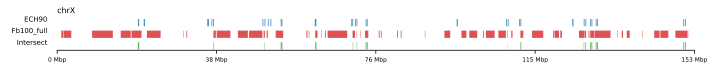

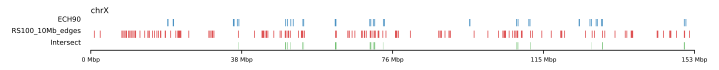

In [33]:
# plot the significant proximity-result
query=ech_dict['edges']
annot= fb100_dict['full']

plot_regions(query, annot, interval_intersect(query, annot), track_titles=['ECH90', 'Fb100_full', 'Intersect'])

# plot some Jaccard-results

query=ech_dict['edges']
annot= edge_df['round_spermatid_100kb_10Mb_edges']

plot_regions(query, annot, interval_intersect(query, annot), track_titles=['ECH90', 'RS100_10Mb_edges', 'Intersect'])

### Do new test with limits (2bp)

In [15]:

# Calcilate the proximity and Jaccard tests
# Annot: Fb, SPA, PAC, RS, SP (edges)
# Query: ECH

# Define the samples

annots = {
    'Fb': dataframes['fibroblast_100kb_arms'], 
    'Spa': dataframes['spermatogonia_100kb_arms'],
    'Pac': dataframes['pachytene_spermatocyte_100kb_arms'],
    'RS': dataframes['round_spermatid_100kb_arms'],
    'Spz': dataframes['sperm_100kb_arms']
}
queries = {
    'ECH': ech90,
    'ECH_lim': make_edges(ech90, 1),
    'Hama_lim': make_edges(high_hama, 1),
    'Olive_lim': make_edges(high_olive, 1)
}

# Run the tests

test_results = {
    'Query': [],
    'Source': [],
    'Type': [],
    'Jaccard': [],
    'Proximity': []
}

for i,(name,annot) in enumerate(annots.items()):
    print(f'{i+1} of {len(annots)}: {name}')

    tmp_annots = {'comps': annot, 
                  'edges': make_edges(annot, 100_000), 
                  'limits': make_edges(annot, 1)}
    
    for tmp_query_key, query in queries.items():
        print(f'\tQuery: {tmp_query_key}')
        for tmp_key, tmp_annot in tmp_annots.items():
            print(f'\t\t{tmp_key}',end=' ')
            _, j_p = jaccard_test(query, tmp_annot)
            print('--> Jaccard done', end=' ')
            query_non_ovl = query.loc[~overlaps(query, tmp_annot)]   
            _, p_p = proximity_test(query_non_ovl, tmp_annot)
            print('--> Proximity done.')

            # Append to results
            test_results['Query'].append(tmp_query_key)
            test_results['Source'].append(name)
            test_results['Type'].append(tmp_key)
            test_results['Jaccard'].append(j_p)
            test_results['Proximity'].append(p_p)

results = pd.DataFrame(test_results)
results

1 of 5: Fb
	Query: ECH
		comps 

--> Jaccard done --> Proximity done.
		edges --> Jaccard done --> Proximity done.
		limits --> Jaccard done --> Proximity done.
	Query: ECH_lim
		comps --> Jaccard done --> Proximity done.
		edges --> Jaccard done --> Proximity done.
		limits --> Jaccard done --> Proximity done.
	Query: Hama_lim
		comps --> Jaccard done --> Proximity done.
		edges --> Jaccard done --> Proximity done.
		limits --> Jaccard done --> Proximity done.
	Query: Olive_lim
		comps --> Jaccard done --> Proximity done.
		edges --> Jaccard done --> Proximity done.
		limits --> Jaccard done --> Proximity done.
2 of 5: Spa
	Query: ECH
		comps --> Jaccard done --> Proximity done.
		edges --> Jaccard done --> Proximity done.
		limits --> Jaccard done --> Proximity done.
	Query: ECH_lim
		comps --> Jaccard done --> Proximity done.
		edges --> Jaccard done --> Proximity done.
		limits --> Jaccard done --> Proximity done.
	Query: Hama_lim
		comps --> Jaccard done --> Proximity done.
		edges --> Jaccard done --> Proximity 

,Query,Source,Type,Jaccard,Proximity
0,ECH,Fb,comps,0.19934,0.82548
1,ECH,Fb,edges,0.01199,0.31260
2,ECH,Fb,limits,0.00530,0.55282
3,ECH_lim,Fb,comps,0.40849,0.65961
4,ECH_lim,Fb,edges,0.03409,0.29474
5,ECH_lim,Fb,limits,1.00000,0.55628
6,Hama_lim,Fb,comps,0.12358,0.62059
7,Hama_lim,Fb,edges,0.87612,0.89615
8,Hama_lim,Fb,limits,1.00000,0.86046
9,Olive_lim,Fb,comps,0.27137,0.36505


In [39]:
q_filter = ['ECH', 'Hama_lim', 'Olive_lim']

results.query('Query in @q_filter and Type == "limits"').sort_values(['Source', 'Type'])

,Query,Source,Type,Jaccard,Proximity
2,ECH,Fb,limits,0.00530,0.55282
8,Hama_lim,Fb,limits,1.00000,0.86046
11,Olive_lim,Fb,limits,1.00000,0.60821
26,ECH,Pac,limits,0.15461,0.69764
32,Hama_lim,Pac,limits,0.00005,0.44405
35,Olive_lim,Pac,limits,0.00004,0.39258
38,ECH,RS,limits,0.00655,0.73480
44,Hama_lim,RS,limits,1.00000,0.78258
47,Olive_lim,RS,limits,1.00000,0.56521
14,ECH,Spa,limits,0.68780,0.23246


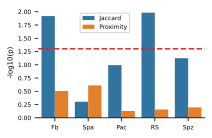

In [31]:
#| label: fig-proximity-jaccard-bar-new
#| fig-cap: Proximity and Jaccard index p-values for ECH90 regions on compartment edges for all cell types at 100kb resolution at arms view $p=0.05$ is marked as a red line.

import matplotlib.pyplot as plt
import seaborn as sns

# Melt the results to a P-value column
test_results_melt = (
    test_results
    .rename(columns={'Jaccard P-value': 'Jaccard', 'Proximity P-value': 'Proximity'})
    .melt(
        id_vars=['Query', 'Annotation'],
        value_vars=['Jaccard', 'Proximity'], 
        var_name='type', value_name='p-value')
    .assign(logp=lambda x: -np.log10(x['p-value']))
)

source_order = ['Fb', 'Spa', 'Pac', 'RS', 'Spz']

f,ax = plt.subplots(figsize=(3,2))

g = sns.barplot(
    data=test_results_melt, x='Annotation', y='logp', hue='type', 
    order=source_order, ax = ax
    )
ax.axhline(-np.log10(0.05), color='tab:red', linestyle='--')


sns.despine(ax=g, left=True)

g.set_ylabel('-log10(p)')
g.set_xlabel('')
g.get_legend().set_title('')
sns.move_legend(g, 'upper center', bbox_to_anchor=(0.4,0.975))



AttributeError: 'NoneType' object has no attribute 'set_title'

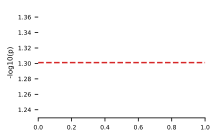

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the results to a P-value column
test_results_melt = (
    results.query('Query == "ECH_limits"')
    .melt(
        id_vars=['Query', 'Source'],
        value_vars=['Jaccard', 'Proximity'], 
        var_name='test', value_name='p-value')
    .assign(logp=lambda x: -np.log10(x['p-value']))
)

source_order = ['Fb', 'Spa', 'Pac', 'RS', 'Spz']

f,ax = plt.subplots(figsize=(3,2))

g = sns.barplot(
    data=test_results_melt, x='Source', y='logp', hue='test', 
    order=source_order, ax = ax
    )
ax.axhline(-np.log10(0.05), color='tab:red', linestyle='--')


sns.despine(ax=g, left=True)

g.set_ylabel('-log10(p)')
g.set_xlabel('')
g.get_legend().set_title('')
sns.move_legend(g, 'upper center', bbox_to_anchor=(0.4,0.975))


### Old test

In [35]:
# # Now we should test

# from genominterv import proximity_test, interval_diff, jaccard_stat, bootstrap

# #query = ech90
# query = edges['round_spermatid_100kb_arms']
# annot_hama = hama_edges
# #annot_olive = baboon_dict['P.anubis']
# b = 1_000

# # Proximity test
# non_ovl_query_hama = interval_diff(query, annot_hama)
# #non_ovl_query_olive = interval_diff(query, annot_olive)

# proximity_hama = proximity_test(non_ovl_query_hama, annot_hama, two_sided=True, samples=10_000)
# #proximity_olive = proximity_test(non_ovl_query_olive, annot_olive, two_sided=True, samples=10_000)

# # Jaccard index

# @bootstrap(chromsizes, samples=b, smaller=False)
# def jaccard_bootstrap(query, annot):
#     return jaccard_stat(query, annot)

# jaccard_hama = jaccard_bootstrap(query, annot_hama)
# #jaccard_olive = jaccard_bootstrap(query, annot_olive)

# print(f"""
# Proximity test results:
#     Hama: {proximity_hama}
#  #   Olive: {proximity_olive}

# Jaccard index results:
#     Hama: {jaccard_hama}
#   #  Olive: {jaccard_olive}
# """)

# # # Swap annot and query 

# # non_ovl_query_hama = interval_diff(annot_hama, query)
# # non_ovl_query_olive = interval_diff(annot_olive, query)

# # proximity_hama_flip = proximity_test(non_ovl_query_hama, query, two_sided=True, samples=b)
# # proximity_olive_flip = proximity_test(non_ovl_query_olive, query, two_sided=True, samples=b)

# # jaccard_hama_flip = jaccard_bootstrap(annot_hama, query)
# # jaccard_olive_flip = jaccard_bootstrap(annot_olive, query)



In [87]:

# Make a long dataframe

# pd.DataFrame({
#     'Group': ['P.hama', 'P.anubis'],
#     #'Proximity Statistic': [proximity_hama.statistic, proximity_olive.statistic],
#     'Proximity P-value': [proximity_hama.pvalue, proximity_olive.pvalue],
#     #'Jaccard Index': [jaccard_hama[0], jaccard_olive[0]],
#     'Jaccard P-value': [jaccard_hama[1], jaccard_olive[1]]
# }).melt(id_vars='Group', var_name='Test', value_name='Value')

pd.DataFrame({
    'Group': ['P.hama', 'P.anubis'],
    #'Proximity Statistic': [proximity_hama.statistic, proximity_olive.statistic],
    'Proximity P-value': [proximity_hama.pvalue, proximity_olive.pvalue],
    #'Jaccard Index': [jaccard_hama[0], jaccard_olive[0]],
    'Jaccard P-value': [jaccard_hama[1], jaccard_olive[1]],
    # #'Proximity Statistic (flip)': [proximity_hama_flip.statistic, proximity_olive_flip.statistic],
    # 'Proximity P-value (flip)': [proximity_hama_flip.pvalue, proximity_olive_flip.pvalue],
    # #'Jaccard Index (flip)': [jaccard_hama_flip[0], jaccard_olive_flip[0]],
    # 'Jaccard P-value (flip)': [jaccard_hama_flip[1], jaccard_olive_flip[1]],
}).melt(id_vars='Group', var_name='Test', value_name='Value')



,Group,Test,Value
0,P.hama,Proximity P-value,0.0069
1,P.anubis,Proximity P-value,0.0274
2,P.hama,Jaccard P-value,0.2720
3,P.anubis,Jaccard P-value,0.8250


### Plot the relative distances (proximities)

In [70]:
ech90.assign(start=ech90['start']-5000,
             end  = ech90['end']+5000)

,chrom,start,end,length
0,chrX,19531773,19641984,100211
1,chrX,20930188,21051124,110936
2,chrX,36218142,36427842,199700
3,chrX,37230935,37637028,396093
4,chrX,49511522,50019126,497604
5,chrX,50816385,51449493,623108
6,chrX,53897995,54111817,203822
7,chrX,62091538,62298349,196811
8,chrX,70884995,71154673,259678
9,chrX,71783766,72149275,355509


In [28]:
# Size of each of the dataframes

print(f"""
rs100_full: {rs100_dict['full'].shape[0]}
rs100_edges: {rs100_dict['edges'].shape[0]}
fb100_full: {fb100_dict['full'].shape[0]}
fb100_edges: {fb100_dict['edges'].shape[0]}
hama_dict: {hama_dict['full'].shape[0]}
ech_dict: {ech_dict['full'].shape[0]}

""")


rs100_full: 77
rs100_edges: 96
fb100_full: 59
fb100_edges: 83
hama_dict: 31
ech_dict: 19




<Axes: xlabel='mid', ylabel='Count'>

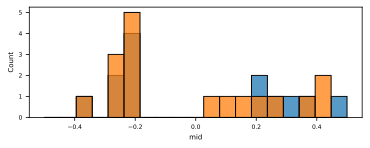

In [42]:
import seaborn as sns
from genominterv.remapping import remap_interval_data

n = 1000
a = np.sort(np.random.randint(1, 10_000_000, size=n))
annot = pd.DataFrame(dict(chrom='chrX', start=a, end=a+10))
q = np.sort(np.random.randint(1, 10_000_000, size=n))
query = pd.DataFrame(dict(chrom='chrX', start=q, end=q+10))
df1 = remap_interval_data(query, annot, relative=True)
df1['mid'] = (df1.start + df1.end) / 2
df1['absmid'] = df1.mid.abs()

# dummy data
a = np.sort(np.random.randint(1, 10_000_000, size=n))
annot = pd.DataFrame(dict(chrom='chrX', start=a, end=a+10))
q = a + np.random.randint(-1000, 1000, size=n)
query = pd.DataFrame(dict(chrom='chrX', start=q, end=q+10))
df2 = remap_interval_data(query, annot, relative=True)
df2['mid'] = (df2.start + df2.end) / 2
df2['absmid'] = df2.mid.abs()

# Real data
q1 = hama_dict['full']
a1 = rs100_dict['full']
df3 = remap_interval_data(q1, a1, relative=True)
df3['mid'] = (df3.start + df3.end) / 2
df3['absmid'] = df3.mid.abs()

q2 = hama_dict['full']
a2 = fb100_dict['full']
df4 = remap_interval_data(q2, a2, relative=True)
df4['mid'] = (df4.start + df4.end) / 2
df4['absmid'] = df4.mid.abs()

sns.histplot(df3, x='mid', bins=np.linspace(-0.5, 0.5, 20))
sns.histplot(df4, x='mid', bins=np.linspace(-0.5, 0.5, 20))

<Axes: xlabel='absmid', ylabel='Count'>

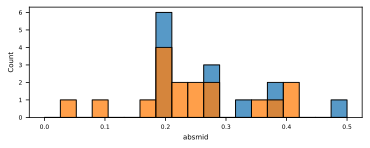

In [47]:
sns.histplot(df3, x='absmid', bins=np.linspace(0, 0.5, 20))
sns.histplot(df4, x='absmid', bins=np.linspace(0, 0.5, 20))

<Axes: xlabel='dist', ylabel='absmid'>

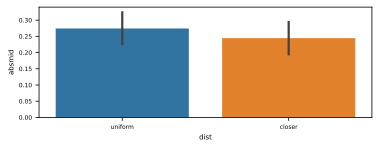

In [45]:
df3['dist'] = 'uniform'
df4['dist'] = 'closer'
df = pd.concat([df3, df4])
sns.barplot(df, y='absmid', x='dist', hue='dist')


## Geneinfo 

How does the edges align with genes?

This first plot is just to figure out how to plot with `gene_plot`.

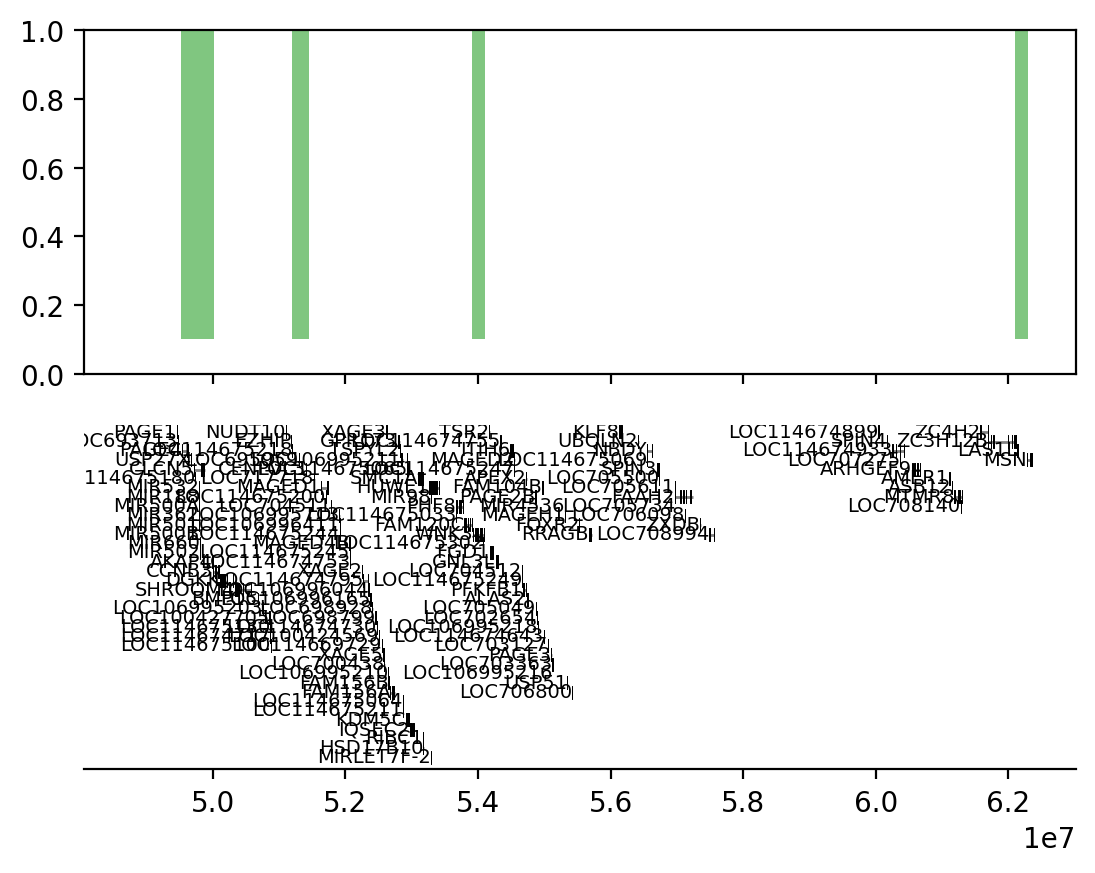

In [15]:
import geneinfo as gi
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection


# Use the proximity test results to plot the ECH90 regions and the compartment edges

start = full_intersect['start'][2]
end = full_intersect['end'][5]

rectangles = [Rectangle((start, 0.1), width=end-start, height=0.9, color='tab:green', linewidth=0, alpha=0.6) for start, end in zip(full_intersect['start'][2:6], full_intersect['end'][2:6])]

pc = PatchCollection(rectangles, match_original=True)

ax = gi.gene_plot('chrX', start-100_000, end+100_000, assembly='rheMac10')
ax.add_collection(pc)

#### Get the geneinfo for all intersections between edges and ECH90

And write to a csv file. If the file exists, read it with pandas.

In [ ]:
# Use get_genes_region
import os.path as op
import geneinfo as gi
import pandas as pd
from os import makedirs as mkdir

genes_dir = '../results/rec_edge_genes/'
if not op.exists(genes_dir):
    mkdir(genes_dir)
    
genes_file = op.join(genes_dir,'rs_edges_100kb_genes.csv')

if not op.exists(genes_file):
    genes = pd.concat(
        full_intersect.apply(
            lambda x: gi.get_genes_region_dataframe('chrX', x['start'], x['end'], assembly='rheMac10'), 
            axis =1
            ).to_list(),
        ignore_index=True
    )
    genes.to_csv(genes_file, index=False) 
else: 
    genes = pd.read_csv(genes_file)

In [18]:
genes_list = genes['name'].unique().tolist()
genes_list

['SH3KBP1',
 'MIR7206',
 'LANCL3',
 'XK',
 'CYBB',
 'LOC696657',
 'DYNLT3',
 'PAGE4',
 'USP27X',
 'CLCN5',
 'LOC114675180',
 'MIR532',
 'MIR188',
 'MIR500A',
 'MIR362',
 'MIR501',
 'MIR500B',
 'MIR660',
 'MIR502',
 'AKAP4',
 'CCNB3',
 'LOC114675218',
 'LOC695959',
 'CENPVL3',
 'FAM120C',
 'WNK3',
 'LOC114675302',
 'ZC3H12B',
 'LAS1L',
 'MSN',
 'ATRX',
 'MAGT1',
 'LOC114675151',
 'COX7B',
 'ATP7A',
 'ALG13',
 'LOC706958',
 'TRPC5',
 'ENOX2',
 'RAP2C',
 'LOC114675176',
 'DKC1',
 'LOC114675231',
 'MPP1',
 'SMIM9',
 'F8',
 'H2AFB3',
 'FUNDC2',
 'CMC4',
 'MTCP1',
 'BRCC3',
 'LOC703257']

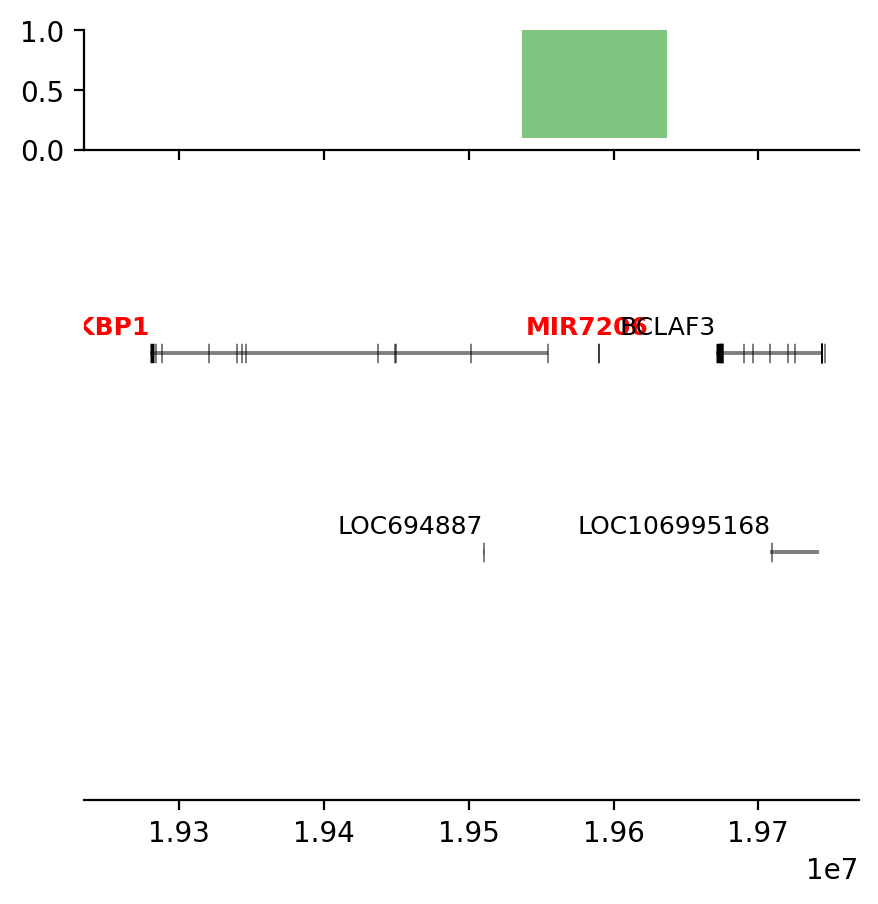

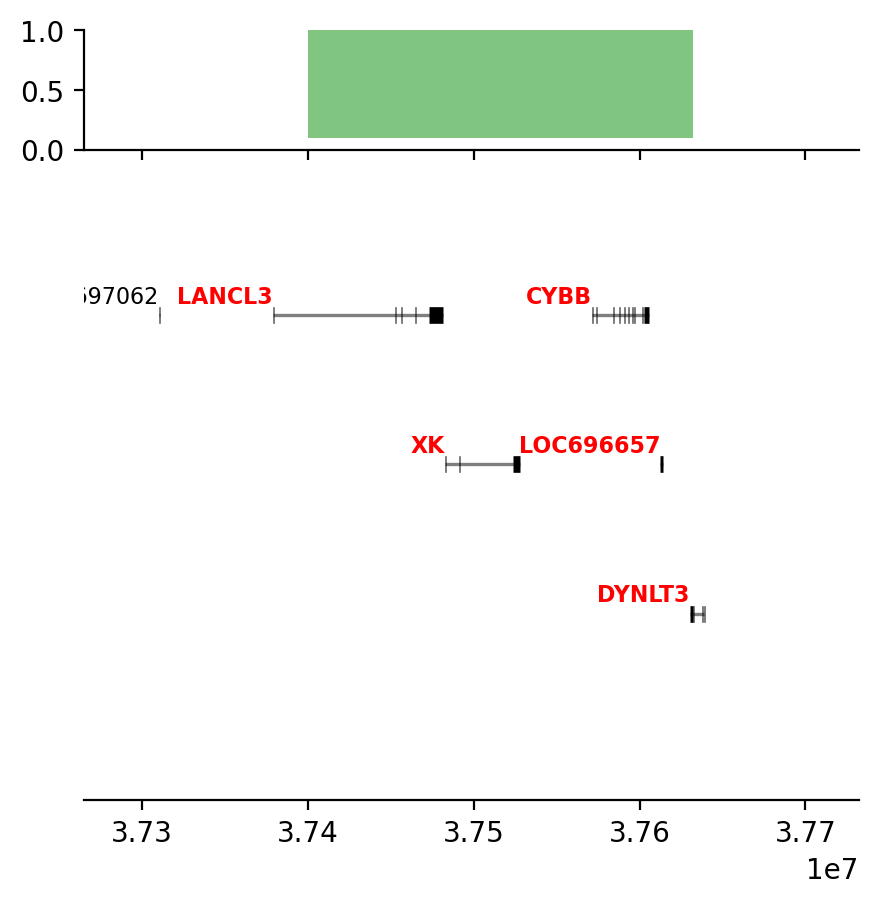

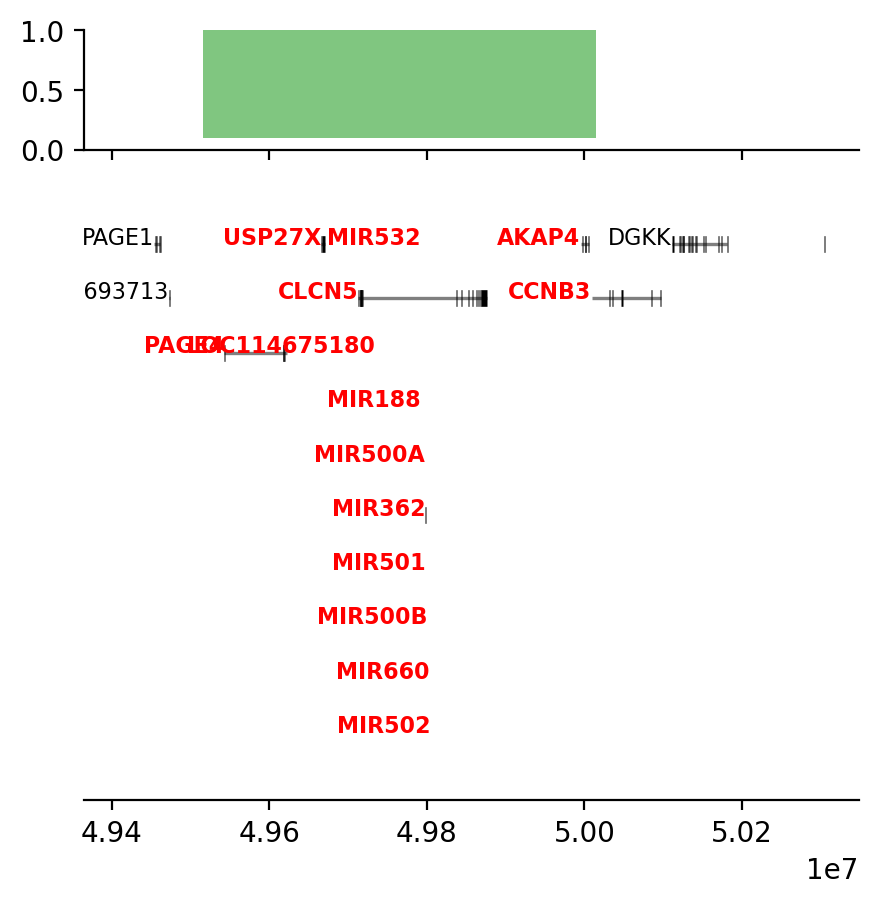

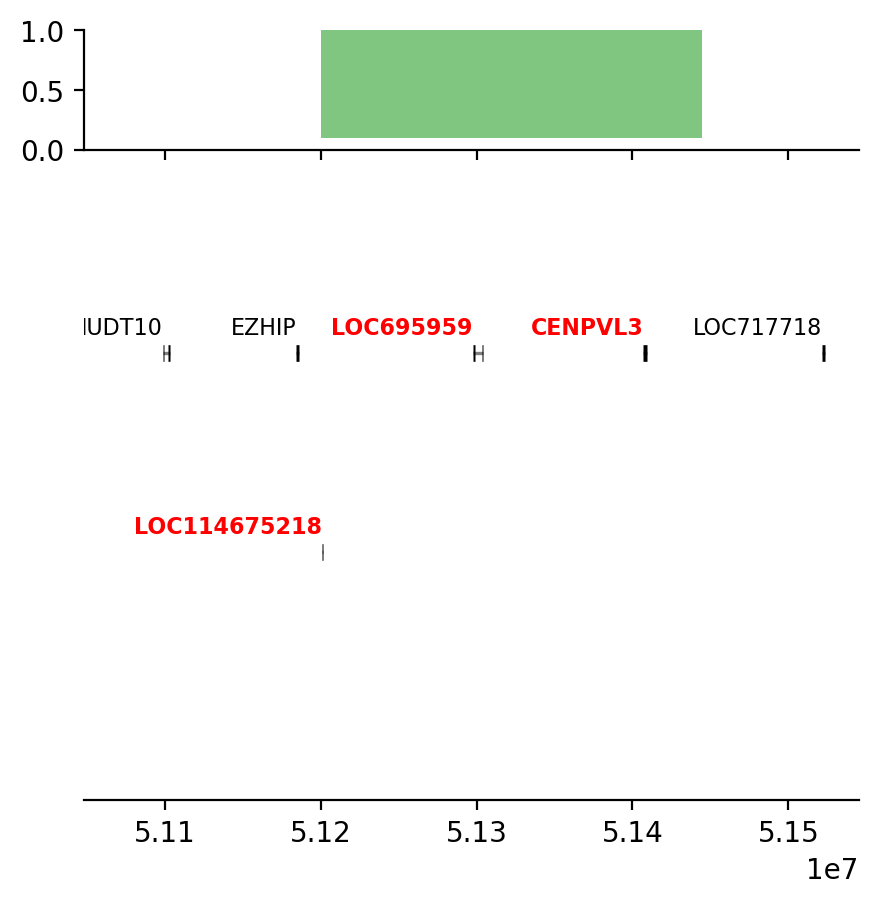

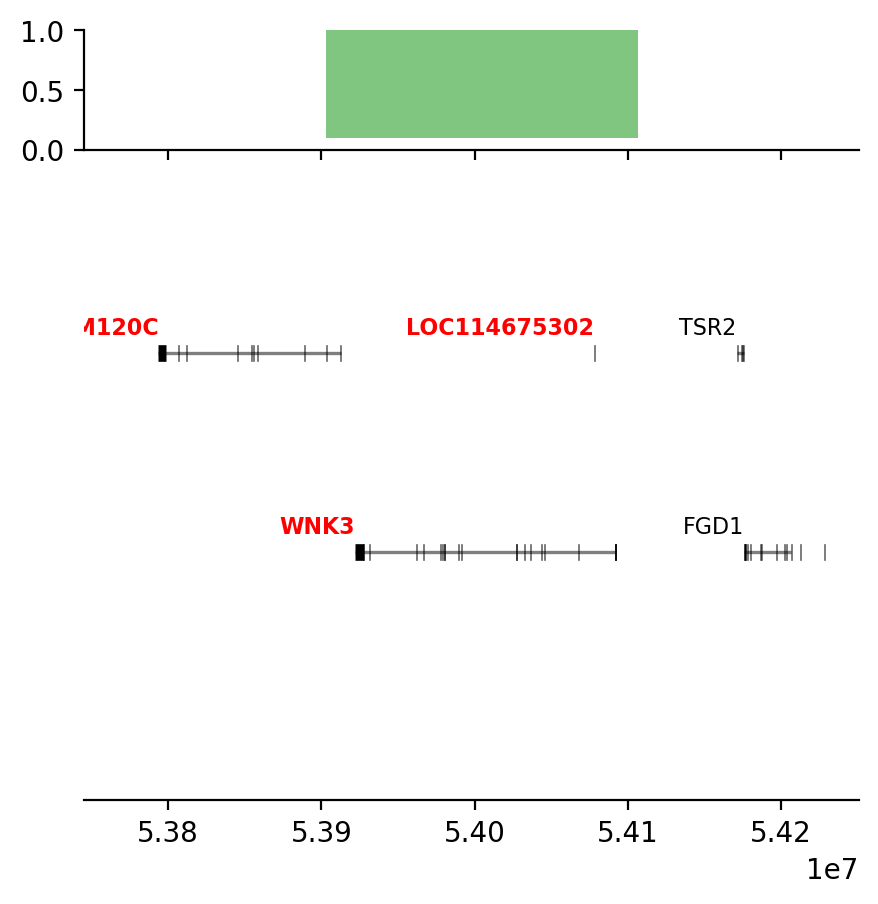

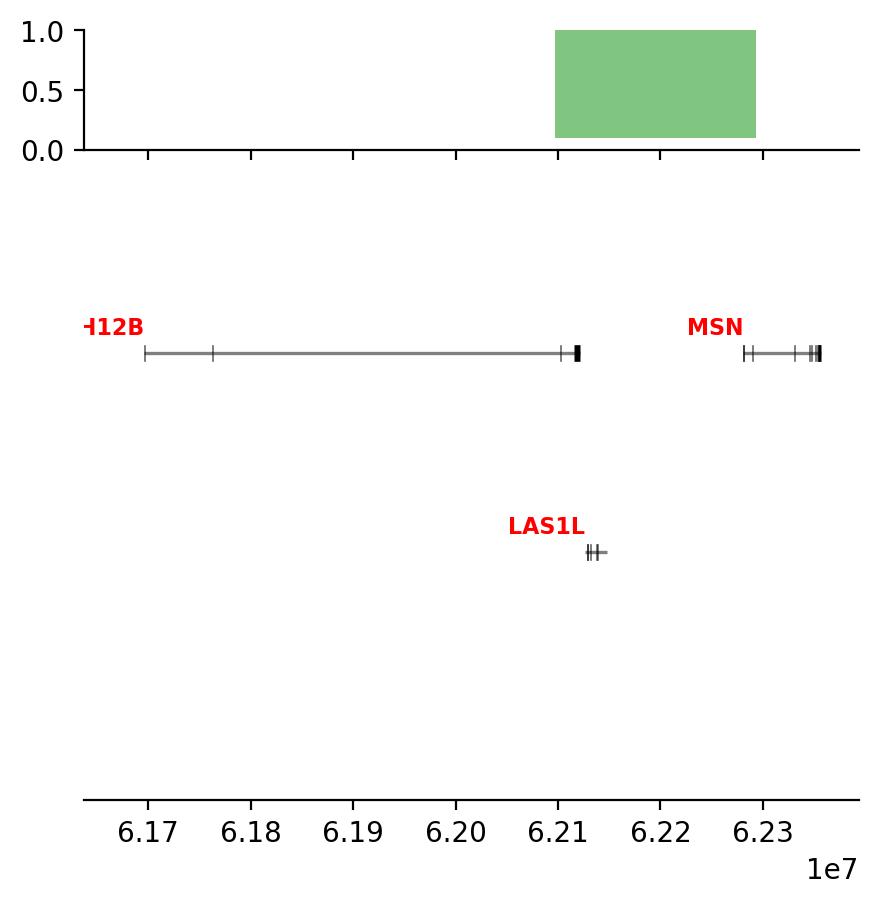

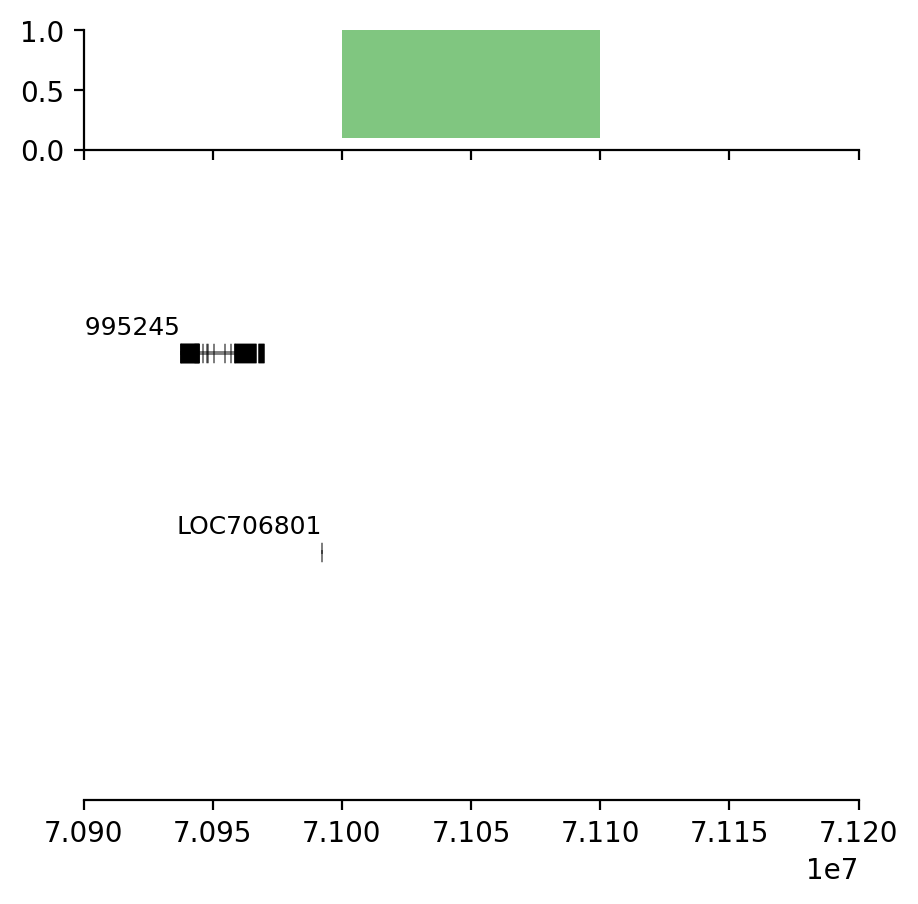

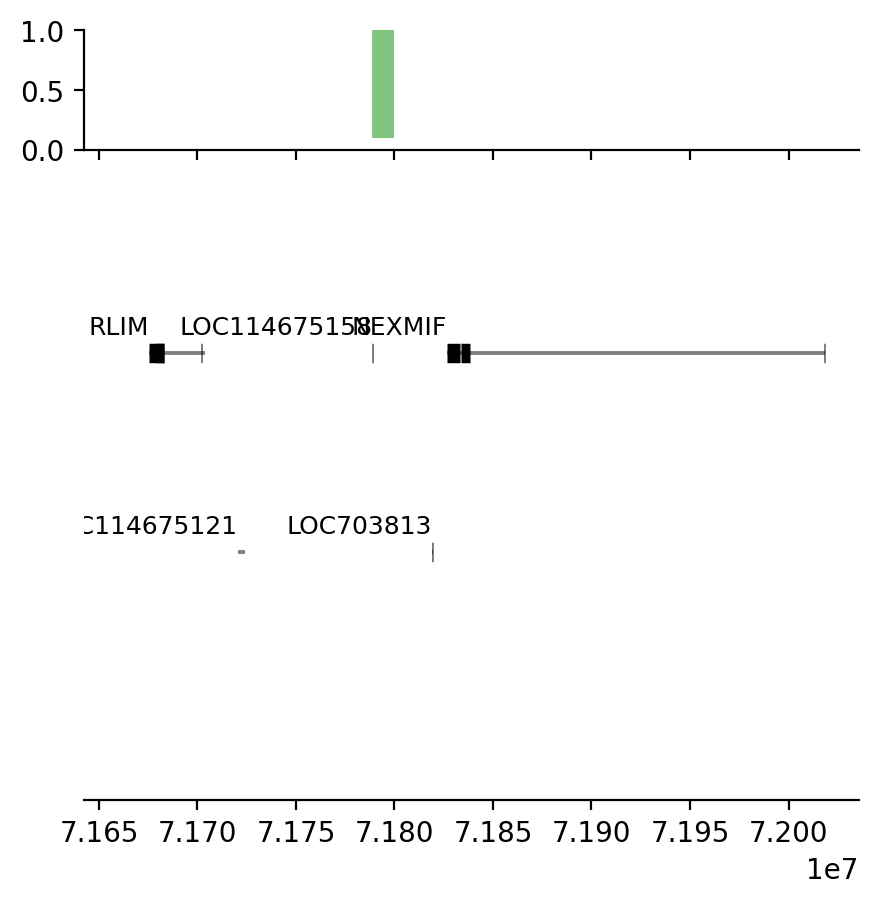

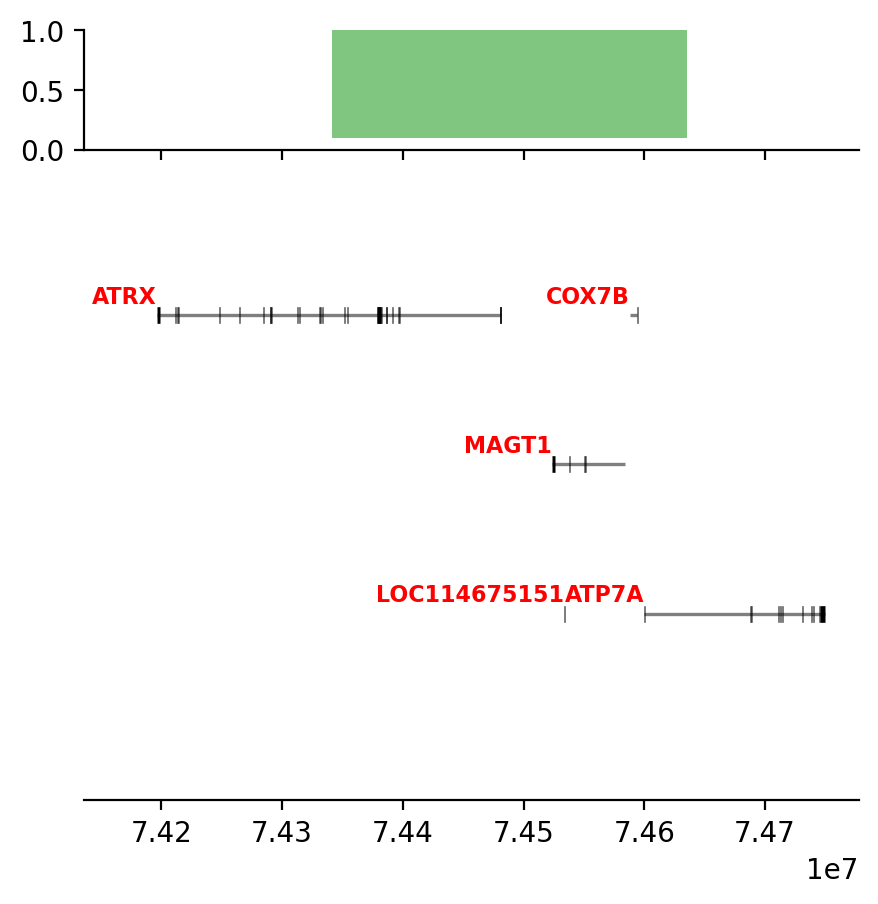

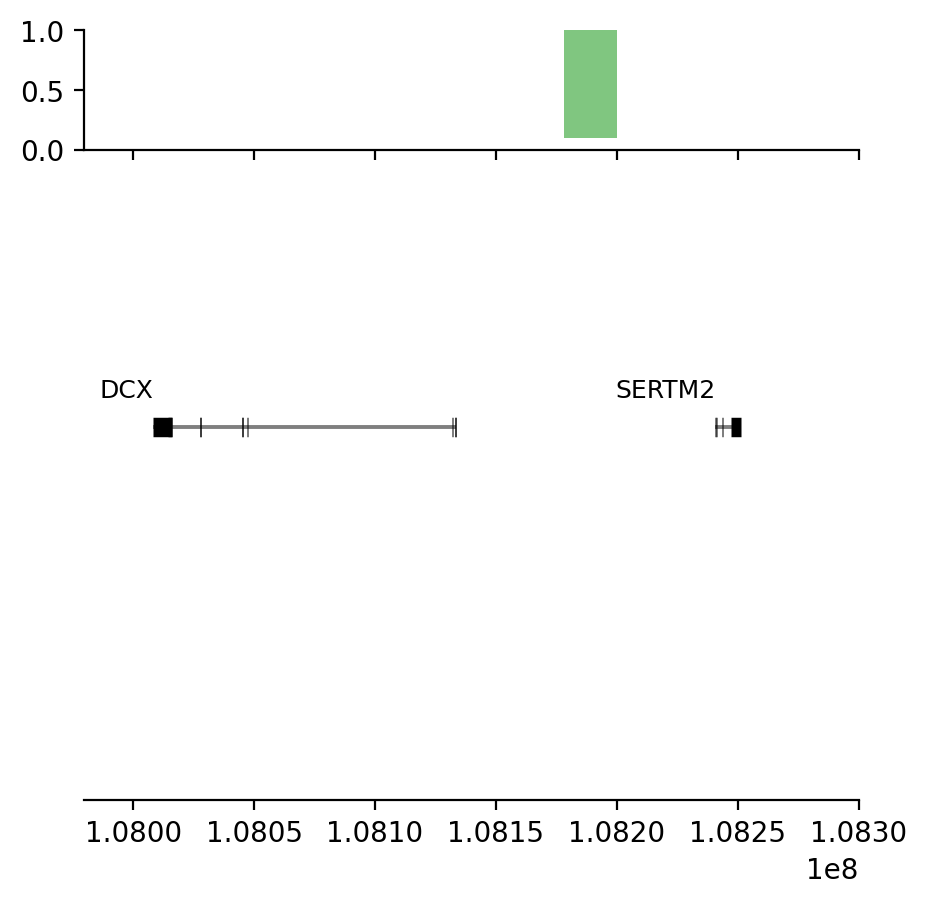

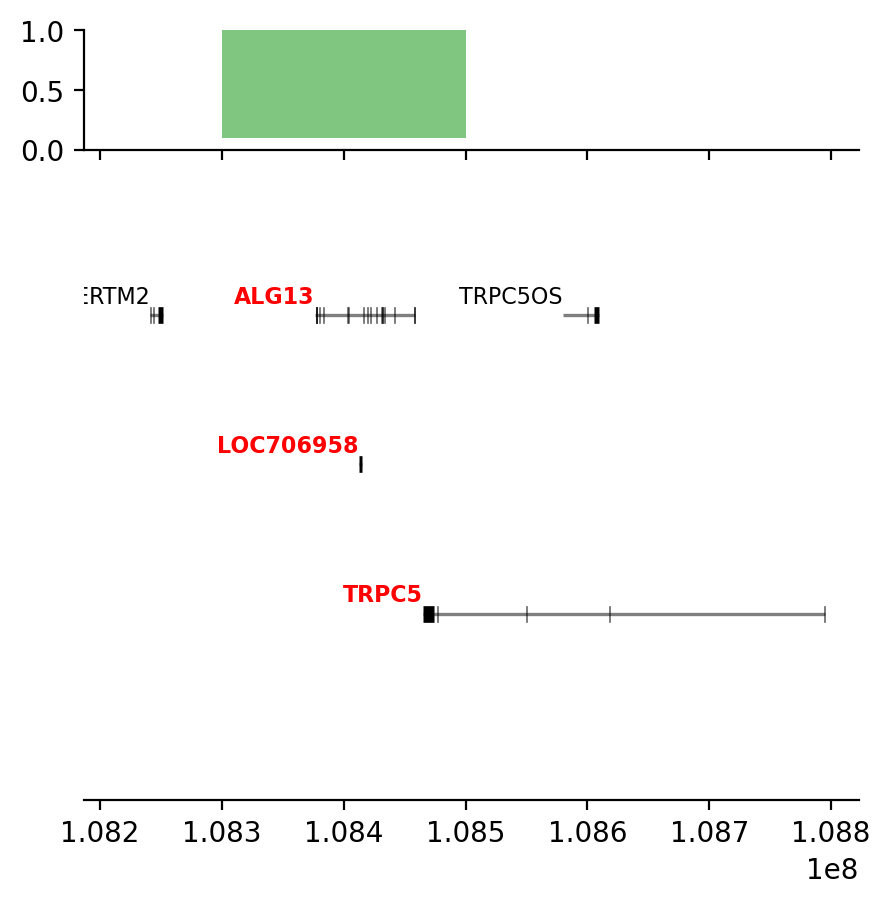

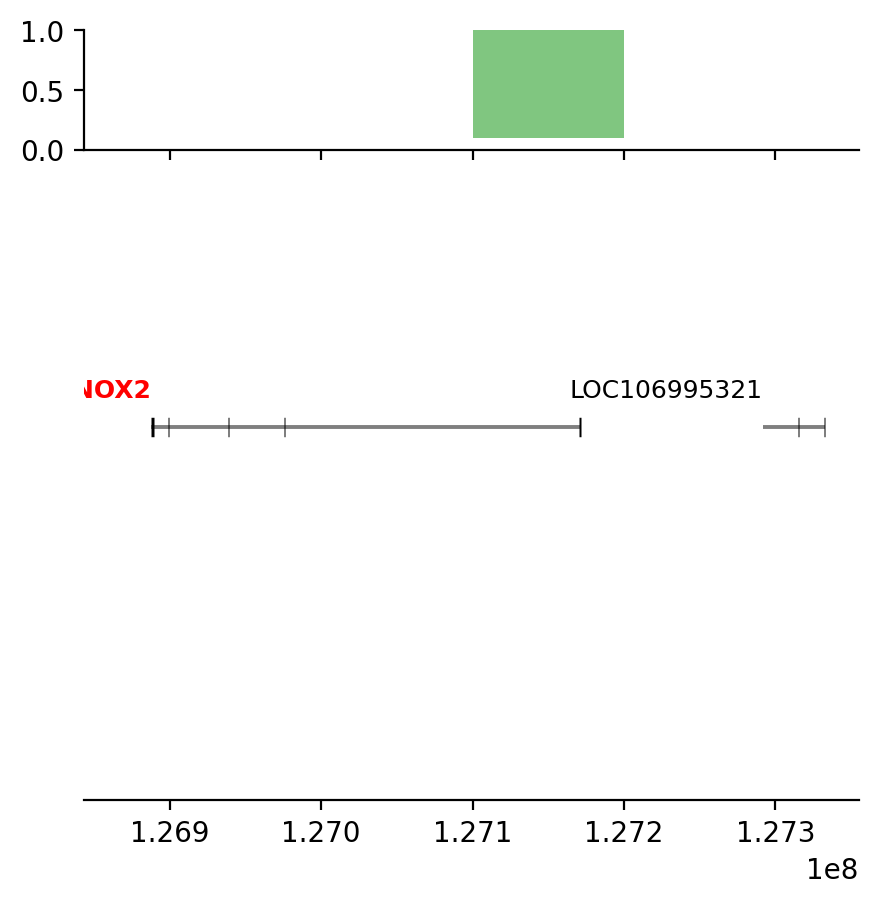

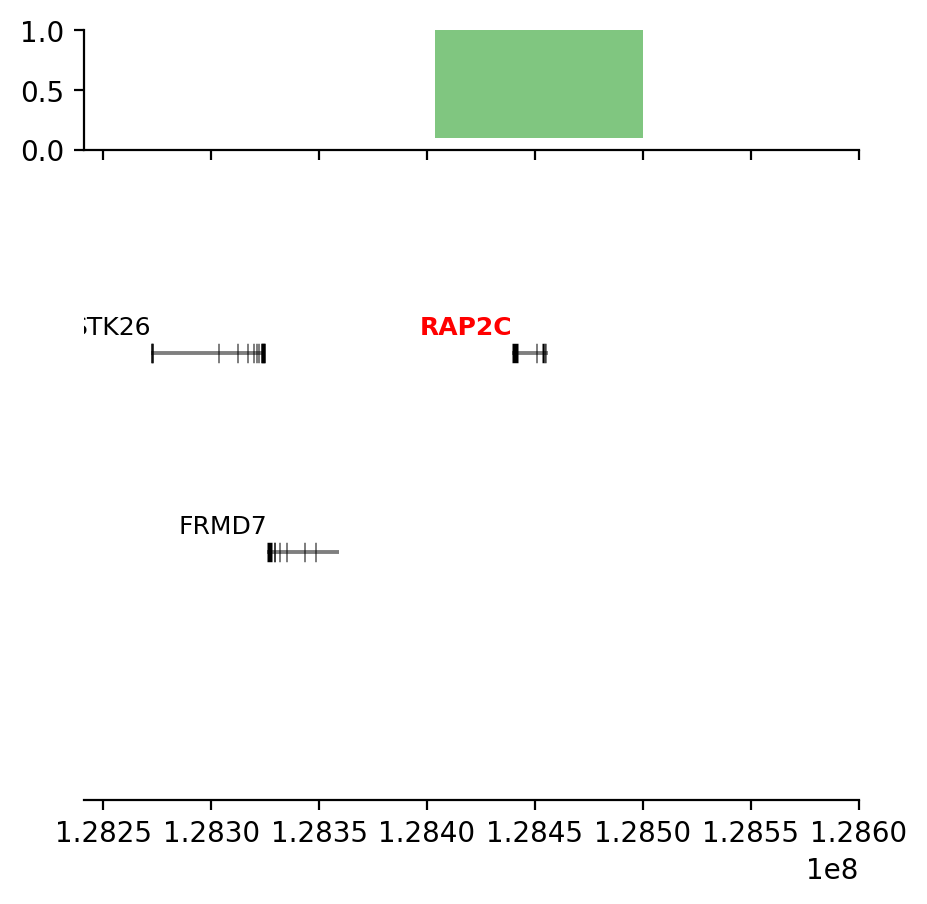

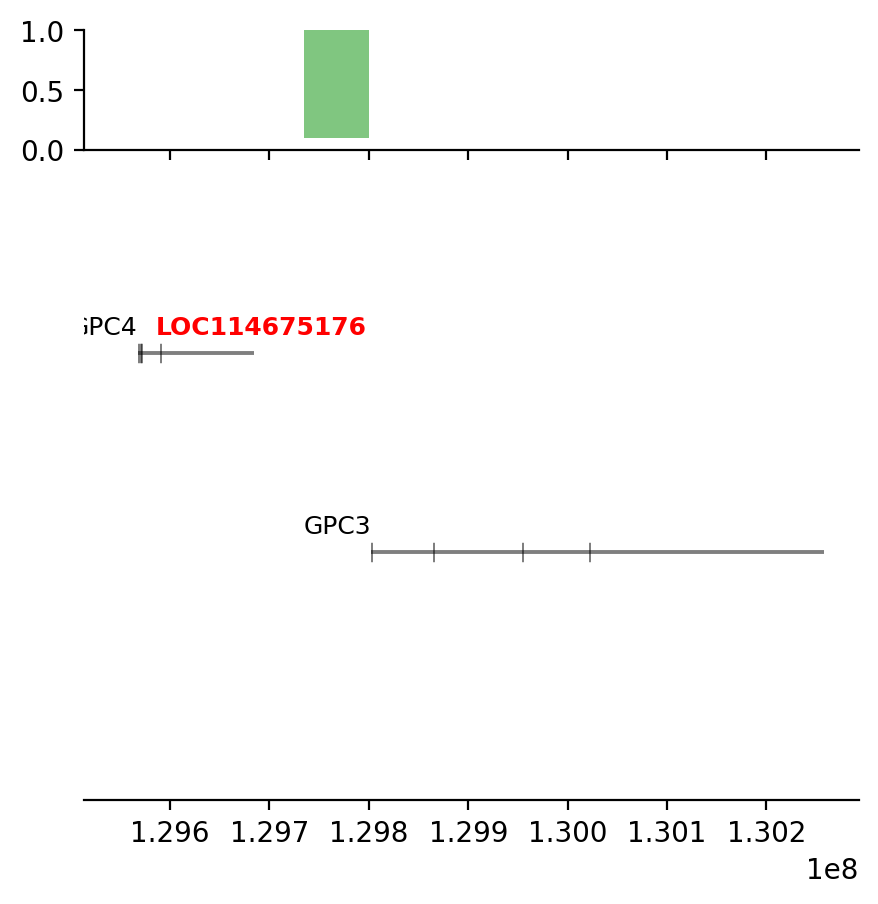

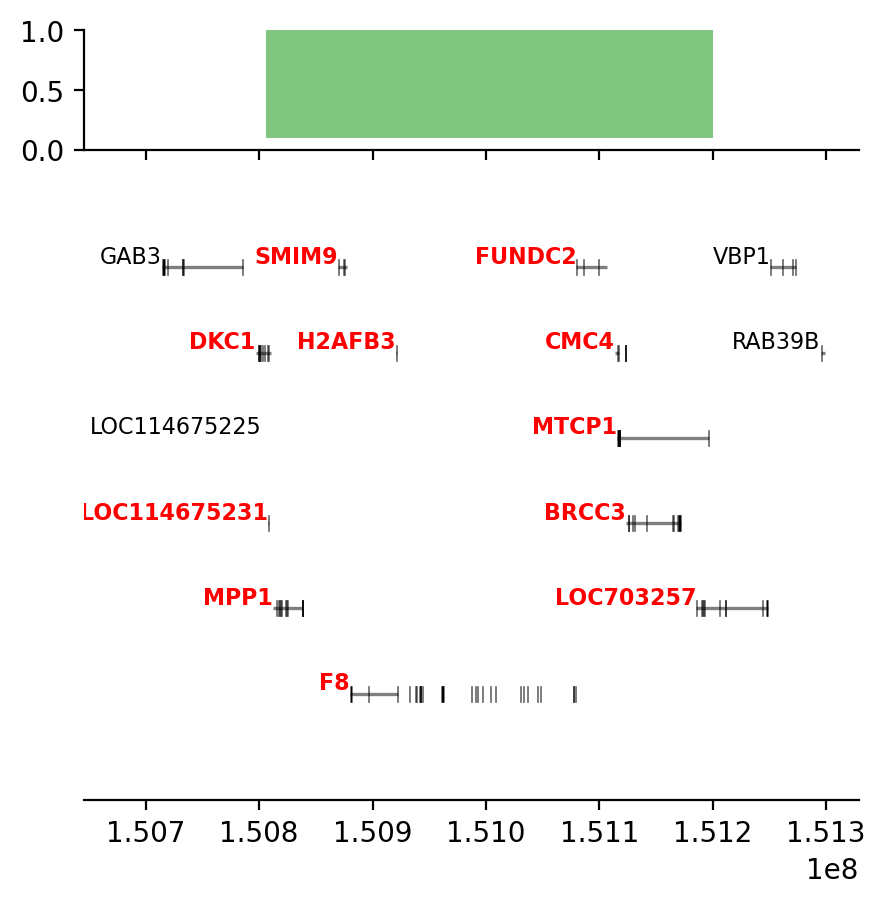

In [27]:
#| 
import geneinfo as gi
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection


# Use the proximity test results to plot the ECH90 regions and the compartment edges

for i in full_intersect.index:
    start_idx = i
    end_idx = i

    start = full_intersect['start'][start_idx]
    end = full_intersect['end'][end_idx]

    rectangles = [Rectangle(
        (start, 0.1), width=end-start, height=0.9, color='tab:green', linewidth=0, alpha=0.6) for start, end in zip(full_intersect['start'][start_idx:end_idx+1], full_intersect['end'][start_idx:end_idx+1])]

    pc = PatchCollection(rectangles, match_original=True)

    ax = gi.gene_plot('chrX', start-100_000, end+100_000, assembly='rheMac10', 
                    highlight=genes_list,
                    despine=True,
                    figsize=(5, 5),
                    aspect=5,
                    )
    ax.add_collection(pc)

### What can I do with the list of genes on the edges?

#### GO enrichment?

In [49]:
mmul_x_genes = gi.get_genes_region_dataframe('chrX', 0, 155_000_000, assembly='rheMac10')

In [50]:
mmul_x_genelist = mmul_x_genes['name'].unique().tolist()

In [51]:
gene_list = genes['name'].unique().tolist()
taxid = 9544
gi.email('sojernj@gmail.com')
#gi.go_annotation_table(taxid=taxid)

#gi.show_go_evidence_codes()

go_terms = gi.get_go_terms_for_genes(gene_list, taxid=taxid)


In [53]:
len(go_terms)
#gene_list[:5]


127

In [55]:
results = gi.go_enrichment(
    # Use human taxid as a start
    gene_list, 
    alpha=0.05,
    terms=go_terms)

geneinfo_cache/go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms; optional_attrs(def relationship)


Could not map gene symbol "MIR7206" to ncbi id
Could not map gene symbol "LOC696657" to ncbi id
Could not map gene symbol "LOC114675180" to ncbi id


HTTPError: 400 Client Error: Bad Request for url: https://rest.ensembl.org/xrefs/id/%5B'ENSG00000207758'%5D